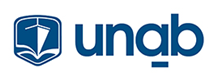
<center>Trabajo Practico Final</center>
<center>Diplomatura en Ciencias Sociales Computacionales.</center> 
<center>Universidad Nacional Guillermo Brown - UnaB.</center>
<br>
<center>Alumna: Marianela Pi</center>


# Introducción
Este trabajo tiene como objetivo aplicar las técnicas aprendidas durante la diplomatura en tres áreas clave: scraping de noticias, predicción de precios y análisis geoespacial. Estos temas se explorarán en el contexto del Día de la Pizza en Buenos Aires, utilizando diversas fuentes de datos.

# Desarrollo
Durante el desarrollo, se analizarán detalladamente los datos, evaluando relaciones y patrones entre variables. Este enfoque nos proporcionará una visión completa de los datos, permitiéndonos responder preguntas clave y detectar anomalías. Cada sección se centrará en técnicas específicas relacionadas con scraping, predicción y geolocalización, proporcionando una comprensión práctica de su aplicación en situaciones del mundo real.

In [3]:
#Una vez que tenemos todas las librerías, vamos a empezar importarlas
import requests
from bs4 import BeautifulSoup as bs4
import pandas as pd
from datetime import datetime,date
import spacy
from nltk.stem import WordNetLemmatizer
# Cargar el modelo de spaCy en español
nlp = spacy.load("es_core_news_sm")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid", {'axes.grid' : False})
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# bibliotecas geo
import os
os.environ['USE_PYGEOS'] = '0'
from owslib.wfs import WebFeatureService
from shapely.ops import nearest_points
from shapely.geometry import LineString
import geopandas as gpd
from shapely.wkt import loads
from pyproj import CRS
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi
from shapely.geometry import Polygon


## Scraping
### **Extracción básica de texto en la Web.**

Cuando trabajamos con *scraping*, tenemos que considerar la interpretación del *código* HTML. Este tipo de lenguaje es en el que se encuentran enmarcadas las plataformas y su correcto entendimiento nos va a permitir ir a buscar el texto o información que estamos buscando.

En este sentido, lo primero que debemos hacer es traernos el *HTML* entero que queremos inspeccionar.

In [4]:
# extraemos la respuesta del parametro que le pasamos, en este caso la url de infobae
response = requests.get (url='https://www.infobae.com/tendencias/2023/02/09/dia-mundial-de-la-pizza-donde-festejar-este-9-de-febrero-en-buenos-aires/')

In [5]:
# transformamos la respuesta que nosotros le pasamos
texto_html = bs4(response.text,'lxml')

In [6]:
# Buscar los elementos <div> con la clase 'deck' que contienen los párrafos de las noticias
parrafos = texto_html.find_all('p', class_='paragraph')

In [7]:
# Obtener el texto de los párrafos y almacenarlos en una lista
lista_parrafos = [parrafo.get_text() for parrafo in parrafos]

In [8]:
# Obtener todos los elementos h2
titulo_tags = texto_html.find_all( 'h2' )  
lista_titulos = [titulo.text for titulo in titulo_tags]

# Me Aseguro de que las listas tengan la misma longitud
min_length = min(len(lista_parrafos), len(lista_titulos))
lista_parrafos = lista_parrafos[:min_length]
lista_titulos = lista_titulos[:min_length]

df_parrafos = pd.DataFrame({'parrafo': lista_parrafos, 'titulo': lista_titulos})

# Filtrar las primeras 5 noticias
df_parrafos.head(5)


parrafo  \
0  En el año 2017 la pizza fue declarada Patrimon...   
1  Finitas o más gruesas, a todos los argentinos ...   
2  De cara a la efeméride del 9 de febrero, te tr...   
3  Spritzza nace para romper con los paradigmas d...   
4  La cocción se da por 50 segundos en un horno d...   

                                              titulo  
0  Una de las comidas más amadas del mundo tiene ...  
1  Dónde celebrar el Día Mundial de la Pizza en B...  
2                                           Spritzza  
3                                      The Pizza OTL  
4                                          Francisca

In [9]:
# Calcular la cantidad de palabras de los párrafos y agregar una columna al DataFrame
df_parrafos['cant._palabras'] = df_parrafos['parrafo'].apply(lambda x: len(x.split()))

In [10]:
df_parrafos.head(5)

parrafo  \
0  En el año 2017 la pizza fue declarada Patrimon...   
1  Finitas o más gruesas, a todos los argentinos ...   
2  De cara a la efeméride del 9 de febrero, te tr...   
3  Spritzza nace para romper con los paradigmas d...   
4  La cocción se da por 50 segundos en un horno d...   

                                              titulo  cant._palabras  
0  Una de las comidas más amadas del mundo tiene ...              44  
1  Dónde celebrar el Día Mundial de la Pizza en B...              53  
2                                           Spritzza              23  
3                                      The Pizza OTL              62  
4                                          Francisca              64

### Escritura de archivo tipo Texto.
Las noticias descargadas las descargamos en un archivo tipo texto. 

In [11]:
# Guardar los datos en un archivo de texto
archivo_salida = 'noticias_dia_de_la_pizza.txt'
with open(archivo_salida, 'w', encoding='utf-8') as archivo:
    for index, row in df_parrafos.head(5).iterrows():
        archivo.write(f"Título: {row['titulo']}\n")
        archivo.write(f"Párrafo: {row['parrafo']}\n")
        archivo.write("-" * 50 + "\n")

print(f"Los datos de las primeras 5 noticias se han guardado en el archivo '{archivo_salida}'")

Los datos de las primeras 5 noticias se han guardado en el archivo 'noticias_dia_de_la_pizza.txt'


### Corpus entero.
Elaboramos un data frame en donde cada fila corresponde a un párrafo de cada noticia.

In [12]:
# Definir la función para procesar un párrafo
def procesar_parrafo(parrafo):
    doc = nlp(parrafo)
    palabras_lematizadas = [token.lemma_ for token in doc]
    entidades = [ent.text for ent in doc.ents]
    return palabras_lematizadas, entidades

# Crear un DataFrame con los datos
df_parrafos = pd.DataFrame({'parrafo': lista_parrafos, 'titulo': lista_titulos})
df_parrafos['cant_palabras'] = df_parrafos['parrafo'].apply(lambda x: len(x.split()))
df_parrafos['entidad'] = df_parrafos['parrafo'].apply(lambda x: [token for token in nlp(x).ents])
df_parrafos['terminos_lematizados'], _ = zip(*df_parrafos['parrafo'].apply(procesar_parrafo))


In [13]:
# Mostrar la tabla
df_parrafos.head(5)

parrafo  \
0  En el año 2017 la pizza fue declarada Patrimon...   
1  Finitas o más gruesas, a todos los argentinos ...   
2  De cara a la efeméride del 9 de febrero, te tr...   
3  Spritzza nace para romper con los paradigmas d...   
4  La cocción se da por 50 segundos en un horno d...   

                                              titulo  cant_palabras  \
0  Una de las comidas más amadas del mundo tiene ...             44   
1  Dónde celebrar el Día Mundial de la Pizza en B...             53   
2                                           Spritzza             23   
3                                      The Pizza OTL             62   
4                                          Francisca             64   

                                             entidad  \
0  [(año), (Patrimonio, Inmaterial, de, la, Human...   
1         [(Italia), (New, York-style), (Argentina)]   
2                                                 []   
3               [(Spritzza), (spritz), (Elaboradas)]   
4                          [(Las, opciones, varían)]   

                                terminos_lematizados  
0  [en, el, año, 2017, el, pizza, ser, declarar, ...  
1  [finita, o, más, grueso, ,, a, todo, el, argen...  
2  [de, cara, a, el, efeméride, del, 9, de, febre...  
3  [Spritzza, nacer, para, romper, con, el, parad...  
4  [el, cocción, él, dar, por, 50, segundo, en, u...

## Predicción precio de la pizza

Los datos utilizados en este análisis se obtuvieron de Kaggle, y aunque provienen de Indonesia, las lecciones y patrones extraídos son aplicables globalmente. A través de este análisis de datos sobre pizzas, exploraremos diversas variables, incluyendo tamaño, ingredientes, precio, y más. Este análisis resalta la versatilidad de la ciencia de datos y su utilidad en la toma de decisiones, sin importar la ubicación geográfica de los datos.

In [14]:
#Cargamos nuestra base de datos
url = 'https://raw.githubusercontent.com/Marian2057/CienciasComputacionales-Unab/main/pizza_v2.csv'
pizza = pd.read_csv(url)
pizza.head(5)

company price_rupiah diameter      topping           variant     size  \
0       A    Rp235,000  22 inch      chicken  double_signature    jumbo   
1       A    Rp198,000  20 inch    papperoni  double_signature    jumbo   
2       A    Rp120,000  16 inch    mushrooms  double_signature  reguler   
3       A    Rp155,000  14 inch  smoked_beef  double_signature  reguler   
4       A    Rp248,000  18 inch   mozzarella  double_signature    jumbo   

  extra_sauce extra_cheese extra_mushrooms  
0         yes          yes              no  
1         yes          yes              no  
2         yes          yes             yes  
3         yes           no             yes  
4         yes           no             yes

In [15]:
#dimensión de la tabla
pizza.shape

(129, 9)

### ¿Qué tipo de columnas son?

Tenemos 9 variables categóricas

In [16]:
#info de la data
pizza.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   company          129 non-null    object
 1   price_rupiah     129 non-null    object
 2   diameter         129 non-null    object
 3   topping          129 non-null    object
 4   variant          129 non-null    object
 5   size             129 non-null    object
 6   extra_sauce      129 non-null    object
 7   extra_cheese     129 non-null    object
 8   extra_mushrooms  129 non-null    object
dtypes: object(9)
memory usage: 9.2+ KB


### Limpieza de datos
Verificamos que la tabla no contenga datos null

In [17]:
# Cambiar el nombre de la columna 'price_rupiah' a 'price'
pizza.rename(columns={'price_rupiah': 'price'}, inplace=True)


In [18]:
#Verificar valores faltantes
pizza.isnull().sum()

company            0
price              0
diameter           0
topping            0
variant            0
size               0
extra_sauce        0
extra_cheese       0
extra_mushrooms    0
dtype: int64

In [19]:
# Convertir columnas de texto a números
pizza["price"] = pizza["price"].str.replace('Rp', '').str.replace(',', '').astype(float)
pizza["diameter"] = pizza["diameter"].str.replace('inch', '').astype(float)

### Análisis y aplicación de Medidas de Tendencia Central

In [20]:
# Obteniendo estadísticas generales sobre el conjunto de datos
pizza.describe()

price    diameter
count     129.000000  129.000000
mean    87151.162791   12.976744
std     44706.097732    3.272674
min     23500.000000    8.000000
25%     51000.000000   12.000000
50%     78000.000000   12.000000
75%    105000.000000   14.000000
max    248000.000000   22.000000

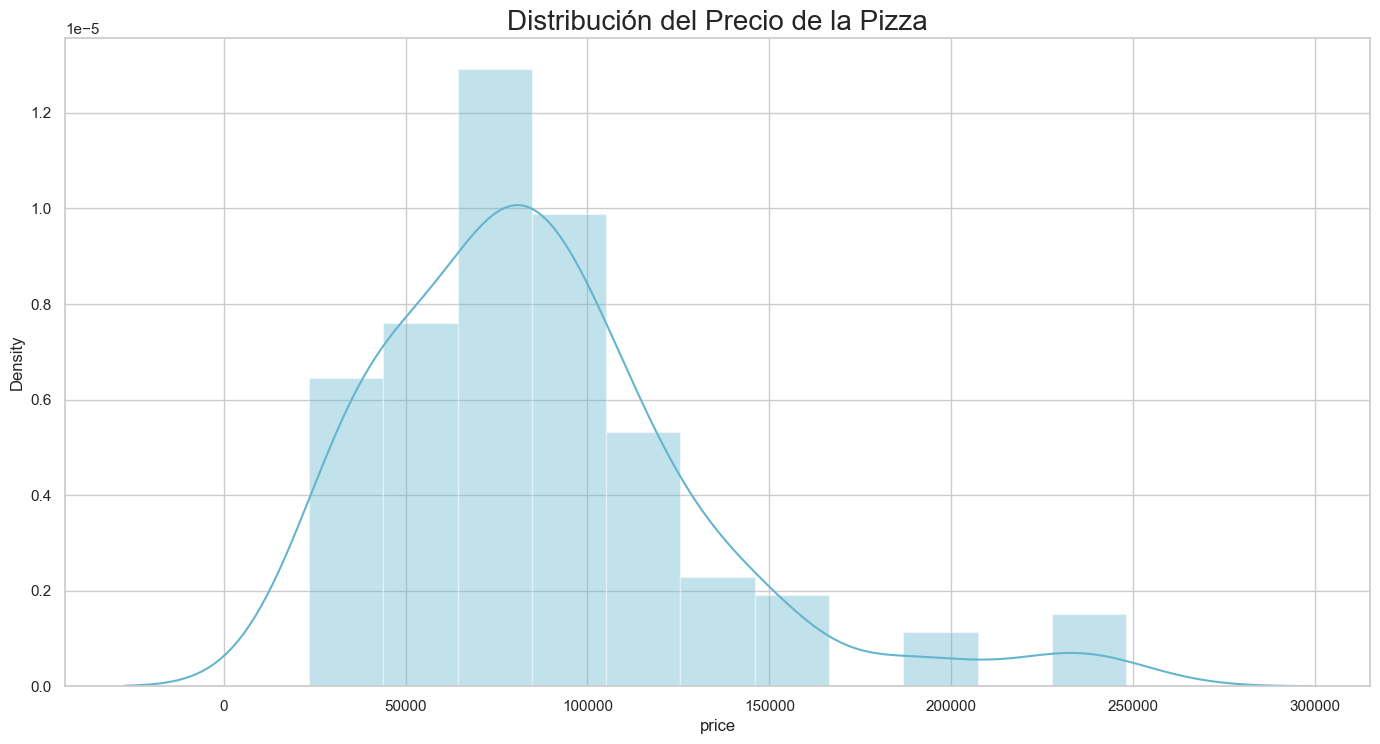

In [21]:
sns.set(style='whitegrid')
f, ax = plt.subplots(1,1, figsize=(15,8))
ax = sns.distplot(pizza['price'], kde = True, color = 'c')
plt.title('Distribución del Precio de la Pizza', size = 20);


En el gráfico podemos observar un sesgo positivo con alineación hacia la derecha en la variable precio

In [22]:
fig = px.bar(pizza, x='diameter', y='price', color="company")
fig.show()

In [23]:
# calculamos la media, moda, mediana
media = pizza['price'].mean()
moda = pizza['price'].mode()[0]
mediana = pizza['price'].median()

print("Media:", media)
print("Moda:", moda)
print("Mediana:", mediana)

Media: 87151.16279069768
Moda: 72000.0
Mediana: 78000.0


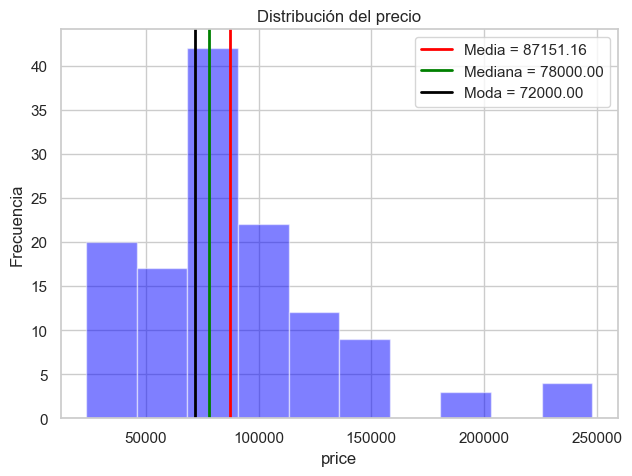

In [24]:
# Cálculo de estadísticas descriptivas
media_price = np.mean(pizza["price"])
mediana_price = np.median(pizza["price"])
min_price = np.min(pizza["price"])
max_price = np.max(pizza["price"])
rango_price = max_price - min_price
std_price = np.std(pizza["price"])
moda_price = pizza["price"].mode()[0]

# Armamos el gráfico
plt.hist(pizza["price"], color='blue', alpha=0.5)
plt.xlabel("price")
plt.ylabel("Frecuencia")
plt.title("Distribución del precio")
plt.axvline(media_price, color='red', linewidth=2, label=f'Media = {media_price:.2f}')
plt.axvline(mediana_price, color='green', linewidth=2, label=f'Mediana = {mediana_price:.2f}')
plt.axvline(moda_price, color='black', linewidth=2, label=f'Moda = {moda_price:.2f}')

plt.legend()
plt.show()

La variable 'precio' tiene una media de aproximadamente 87151.16. Esto indica que, en promedio, los valores tienden a estar alrededor de este punto central, lo que sugiere una tendencia central en los datos.
Además, la moda de 72000.0 nos indica que el valor 72000.0 es el más común en nuestro conjunto de datos, es decir, es el valor que aparece con mayor frecuencia.
Por otro lado, la mediana de 78000.0 nos dice que la mitad de los datos tiene valores por debajo de este número y la otra mitad tiene valores por encima de él cuando los datos están ordenados. Esto proporciona una medida de tendencia central que es menos sensible a valores atípicos en comparación con la media y resalta cómo se distribuyen los datos en torno a este punto medio.

In [25]:
print(f"La cantidad mínima de precio es: {min_price}")
print(f"La cantidad máxima de precio es: {max_price}")
print(f"El rango de precio es: {rango_price}")
print(f"El error standard de precio es: {std_price:.4f}")

La cantidad mínima de precio es: 23500.0
La cantidad máxima de precio es: 248000.0
El rango de precio es: 224500.0
El error standard de precio es: 44532.4812


### Medidas de Dispersión.

#### Calculamos la varianza 

In [26]:
variance = pizza.var()

print(variance)

price       1.998635e+09
diameter    1.071039e+01
dtype: float64


#### Curtosis

In [27]:
#Importamos la librería.
from scipy.stats import kurtosis

#Generamos un nuevo conjunto filtrado sin los valores nulos
base_nueva = pizza[pizza['price']>=1]
#base_nueva = base_nueva[:100]

#Aplicamos el método
kurtosis(base_nueva['price'])

2.2684339806384255

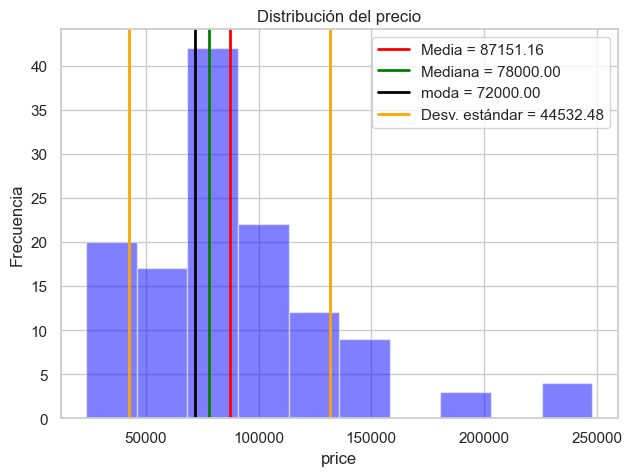

Desviación estándar: 44532.48116255009
Varianza: 1983141878.4928787
Rango intercuartil: 54000.0
Coeficiente de variación: 51.09797705109149


In [28]:
# Calculamos las medidas de dispersión
std_price = np.std(pizza["price"])
var_price = np.var(pizza["price"])
iqr_price = np.subtract(np.percentile(pizza["price"], 75), np.percentile(pizza["price"], 25))
cv_price = (std_price / media_price) * 100

# Armamos el gráfico
plt.hist(pizza["price"], color='blue', alpha=0.5)
plt.xlabel("price")
plt.ylabel("Frecuencia")
plt.title("Distribución del precio")
plt.axvline(media_price, color='red', linewidth=2, label=f'Media = {media_price:.2f}')
plt.axvline(mediana_price, color='green', linewidth=2, label=f'Mediana = {mediana_price:.2f}')
plt.axvline(moda_price, color='black', linewidth=2, label=f'moda = {moda_price:.2f}')
plt.axvline(media_price + std_price, color='orange', linewidth=2, label=f'Desv. estándar = {std_price:.2f}')
plt.axvline(media_price - std_price, color='orange', linewidth=2)
plt.legend()
plt.show()

# Imprimimos las medidas de dispersión
print("Desviación estándar:", std_price)
print("Varianza:", var_price)
print("Rango intercuartil:", iqr_price)
print("Coeficiente de variación:", cv_price)

Desviación estándar: La desviación estándar es de aproximadamente 44532.48. Esto indica que los valores tienden a variar alrededor de la media en promedio en esta cantidad. En otras palabras, muestra cuánta dispersión o variabilidad existe en los datos con respecto a la media.
Varianza: La varianza es de aproximadamente 1983141878,49. Es una medida de la dispersión de los datos. Valores más altos de varianza indican una mayor variabilidad en los datos.
Rango intercuartil (IQR): El rango intercuartil es de 540.0. Representa la diferencia entre el tercer cuartil (Q3) y el primer cuartil (Q1) en la distribución de datos. El IQR es útil para comprender la dispersión de los datos en la parte central de la distribución y es menos sensible a valores atípicos que el rango completo.
Coeficiente de variación: El coeficiente de variación es de aproximadamente 51.10%. Esta medida relativa expresa la desviación estándar como un porcentaje de la media. Un coeficiente de variación más alto indica una mayor variabilidad en relación con la media.

### Analizamos las variables del dataset
1. Precio

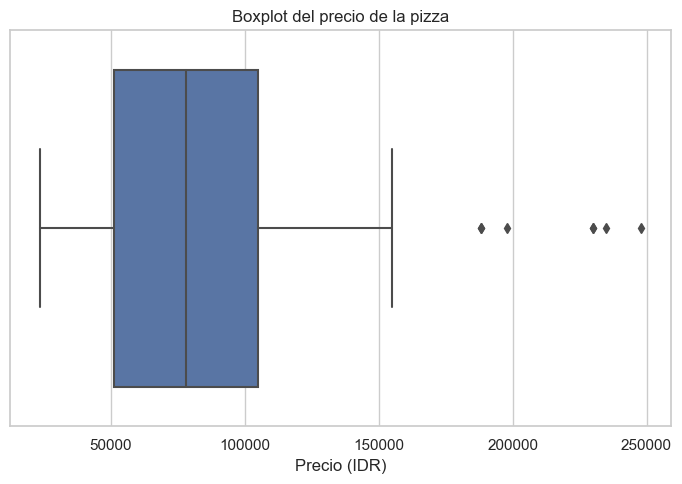

In [29]:
#boxplot del precio de la pizza
fig=plt.figure(figsize=(7,5))
sns.boxplot(x='price', data=pizza)
plt.title("Boxplot del precio de la pizza")
plt.xlabel("Precio (IDR)")
plt.tight_layout()
plt.show(fig)

Como podemos observar en el gráfico hay algunos valores atípicos en la variable de precio, con un precio máximo de 250000.

2- Diametro de la pizza

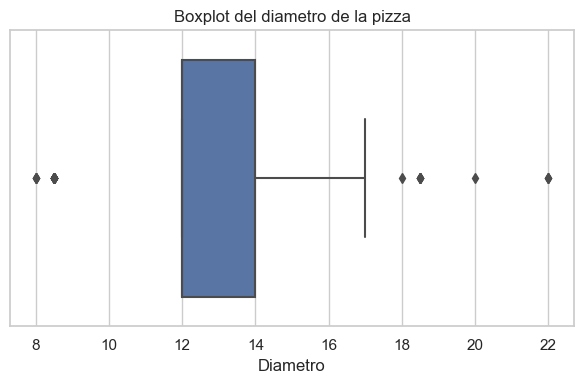

In [30]:
#boxplot del diametro
fig=plt.figure(figsize=(6,4))
sns.boxplot(x='diameter', data=pizza)
plt.title("Boxplot del diametro de la pizza")
plt.xlabel("Diametro")
plt.tight_layout()
plt.show(fig)



Hay valores atípicos en la variable "diameter" con un mínimo de 8 y un máximo de 22. Esto significa que en el conjunto de datos de diámetros de pizzas, algunos diámetros caen fuera del rango típico de 8 a 12, y se consideran valores atípicos o extremos. Estos valores pueden tener un impacto en el análisis y deben ser examinados más detenidamente para determinar si son errores de entrada o datos legítimos pero inusuales.

3- Empresas

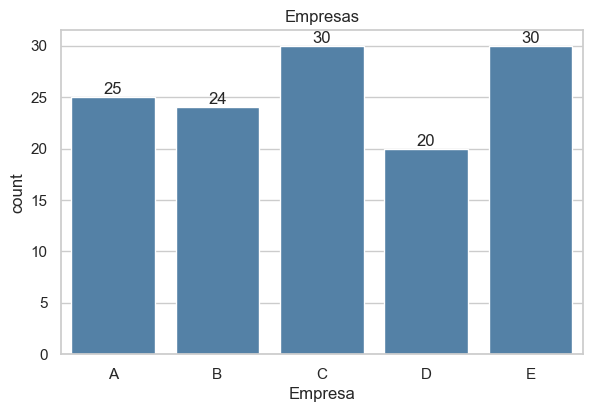

In [31]:
#conteo por empresa
plt.figure(figsize=(6,4))
fig = sns.countplot(x = "company", data = pizza, color="steelblue")
plt.xlabel('Empresa')
plt.title("Empresas")
for i in fig.containers :
    fig.bar_label(i)
plt.show(fig)

Existen 5 empresas que producen pizzas. La empresa que produce la mayor cantidad de pizzas es la empresa C y la empresa E. Esto significa que, entre las 5 empresas productoras de pizza, las empresas C y E son las que tienen la producción más alta en comparación con las demás. Estas dos empresas, C y E, son los principales productores de pizza en el conjunto de datos o contexto en cuestión.

4- Ingredientes

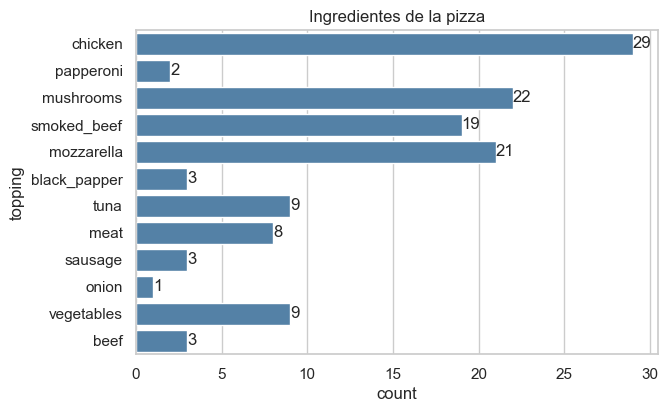

In [32]:
#Recuento de ingredientes
plt.figure(figsize=(6,4))
fig = sns.countplot(y = "topping", data = pizza, color="steelblue")
plt.title("Ingredientes de la pizza")
for i in fig.containers :
    fig.bar_label(i)
plt.show(fig)

Existen 12 ingredientes para las pizzas, y el ingrediente que más gusta a los clientes es el pollo. Esto indica que, entre los 12 ingredientes disponibles para las pizzas, el pollo es el más popular y preferido por los clientes en términos de elección de ingredientes para sus pizzas. Los clientes muestran una preferencia destacada por el pollo en comparación con los otros ingredientes disponibles.

5- Variantes

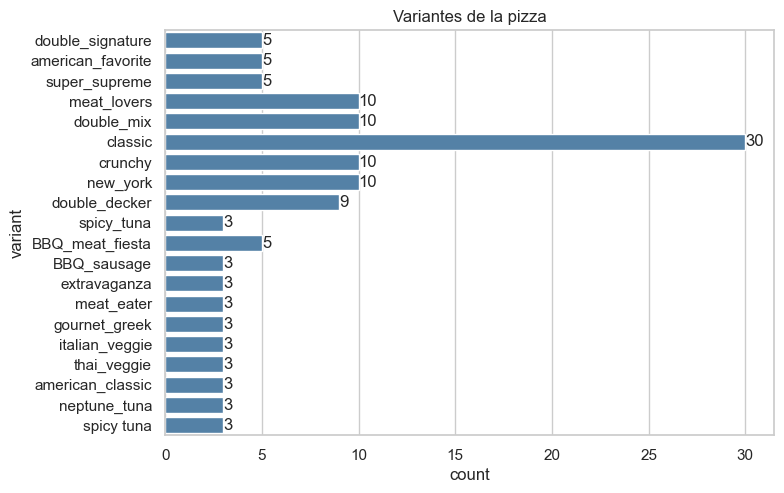

In [33]:
#recuento de variantes
plt.figure(figsize=(7,5))
fig = sns.countplot(y = "variant", data = pizza, color="steelblue")
plt.title("Variantes de la pizza")
for i in fig.containers :
    fig.bar_label(i)
plt.show(fig)

Existen 20 variantes de pizza, y la variante clásica es la que más gusta a los clientes. Esto indica que, entre las 20 variantes de pizza disponibles, la variante clásica es la más popular y preferida por los clientes en términos de elección de pizza. Los clientes muestran una preferencia destacada por la variante clásica en comparación con las otras opciones disponibles.

7- Tamaño

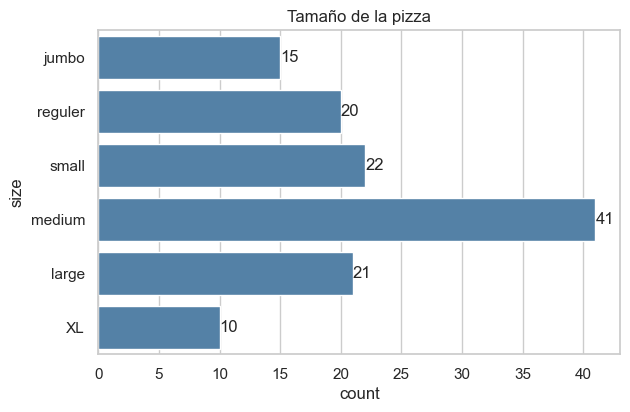

In [34]:
#conteo del tamaño
plt.figure(figsize=(6,4))
fig = sns.countplot(y = "size", data = pizza, color="steelblue")
plt.title("Tamaño de la pizza")
for i in fig.containers :
    fig.bar_label(i)
plt.show(fig)

Hay 6 tamaños de pizza y el tamaño mediano es el más preferido.

8 Salsa extra

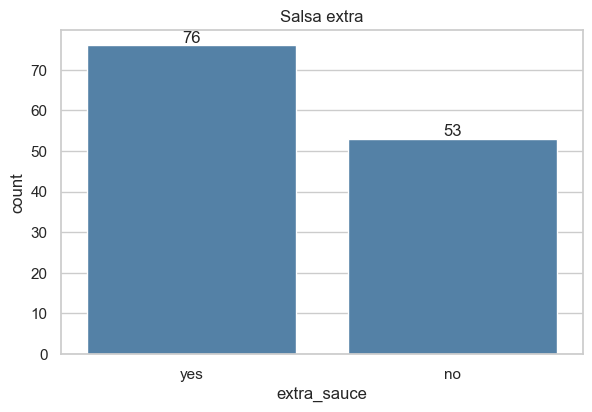

In [35]:
#conteo extra salsa
plt.figure(figsize=(6, 4))
fig = sns.countplot(x = "extra_sauce", data = pizza, color="steelblue")
plt.title("Salsa extra")
for i in fig.containers :
    fig.bar_label(i)
plt.show(fig)

En el gràfico podemos observar que a a mayoría de los clientes les gusta agregar salsa a su pizza.

9 Extra Queso

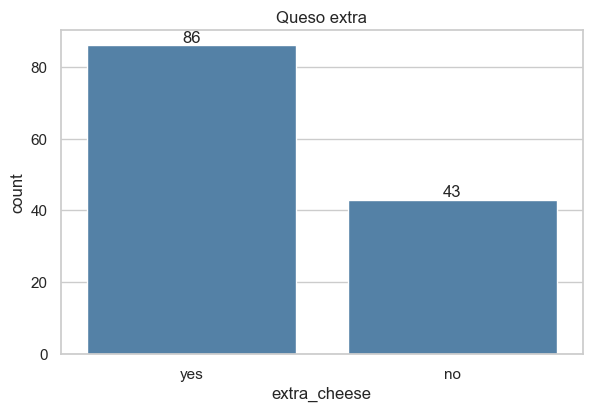

In [36]:
#recuento de  extra queso
plt.figure(figsize=(6, 4))
fig = sns.countplot(x = "extra_cheese", data = pizza, color="steelblue")
plt.title("Queso extra")
for i in fig.containers :
    fig.bar_label(i)
plt.show(fig)

En el gráfico de queso extra observamos que a la mayoría de los clientes les gusta agregar queso a su pizza.

In [37]:
#Precio promedio de pizza por empresa
co_pr = pizza.groupby("company")["price"].mean().reset_index(name="Average price").sort_values(by="Average price",ascending=False)
co_pr

company  Average price
0       A  131440.000000
3       D   98375.000000
4       E   73866.666667
1       B   73708.333333
2       C   66800.000000

"La empresa A produce pizzas con el precio promedio más alto."

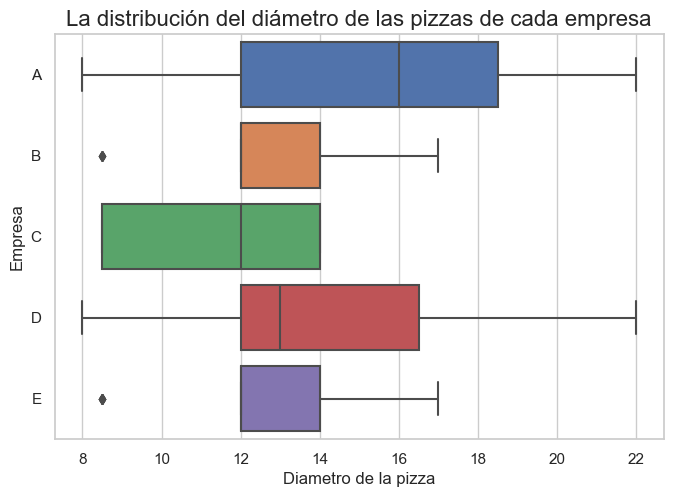

In [38]:
#Diagrama de caja del diámetro de la pizza por empresa
fig=plt.figure(figsize=(7,5))
sns.boxplot(x="diameter", y="company", orient="h", 
            data=pizza, saturation=0.90)
plt.title("La distribución del diámetro de las pizzas de cada empresa", fontsize = 16)
plt.xlabel("Diametro de la pizza")
plt.ylabel("Empresa")
plt.show()

La empresa A y C tienen el diámetro más grande y más pequeño de todas las empresas.

La empresa A produce pizzas con el precio promedio más alto

In [39]:
#Recuento de ingredientes por empresa
co_tp = pizza.groupby("company")["topping"].nunique().reset_index(name="Count of topping")
co_tp

company  Count of topping
0       A                 6
1       B                 4
2       C                 8
3       D                 4
4       E                 6

La empresa C tiene la mayor cantidad de ingredientes

In [40]:
#Precio promedio de pizza para cada ingrediente
tp_pr = pizza.groupby("topping")["price"].mean().reset_index(name="Average price").sort_values(by="Average price",ascending=False)
tp_pr

topping  Average price
7      papperoni  134000.000000
1   black_papper  113333.333333
9    smoked_beef  100315.789474
2        chicken   95551.724138
4     mozzarella   87357.142857
5      mushrooms   87272.727273
8        sausage   70000.000000
3           meat   67750.000000
11    vegetables   66666.666667
10          tuna   66444.444444
0           beef   64333.333333
6          onion   60000.000000

El ingrediente de pepperoni tiene el precio promedio más alto en las pizzas

In [41]:
#Precio promedio de pizza para cada tamaño
sz_dm = pizza.groupby("size")["diameter"].aggregate(["min", "max"]).reset_index().sort_values(by="min")
sz_dm

size   min   max
4  reguler   8.0  16.5
5    small   8.5   8.5
3   medium  12.0  12.0
2    large  14.0  14.0
1    jumbo  16.0  22.0
0       XL  17.0  17.0

Como era de esperar, el tamaño jumbo tiene el diámetro máximo, mientras que el tamaño regular tiene el diámetro mínimo más bajo.

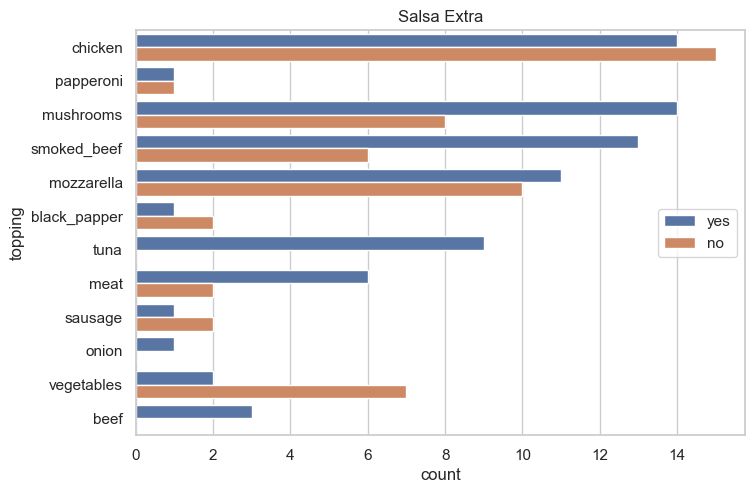

In [42]:
#Ingrediente con salsa extra
fig=plt.figure(figsize=(7,5))
sns.countplot(data=pizza, y="topping", hue="extra_sauce")
plt.title("Salsa Extra")
plt.legend(loc="center right")
plt.show()

La mayoría de los ingredientes para la pizza se prefieren con salsa extra. Solo el pollo, la pimienta negra, la salchicha y los vegetales no se prefieren con salsa extra.

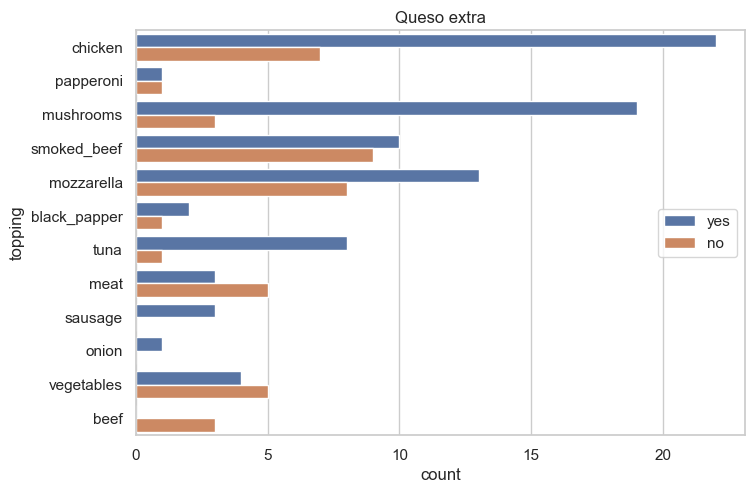

In [43]:
#Ingrediente con extra queso
fig=plt.figure(figsize=(7,5))
sns.countplot(data=pizza, y="topping", hue="extra_cheese")
plt.title("Queso extra")
plt.legend(loc="center right")
plt.show()

La mayoría de los ingredientes para la pizza se prefieren con queso extra. Solo la carne, los vegetales y el bifé no se prefieren con queso extra

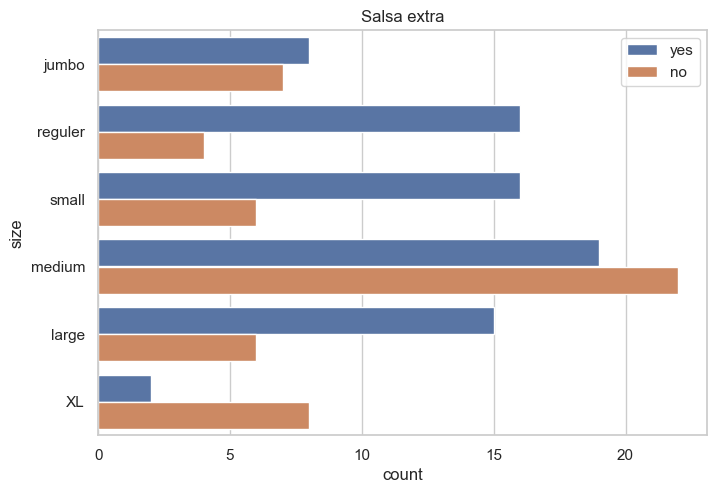

In [44]:
#Tamaño con Salsa extra
fig=plt.figure(figsize=(7,5))
sns.countplot(data=pizza, y="size", hue="extra_sauce")
plt.title("Salsa extra")
plt.legend(loc="upper right")
plt.show()

La mayoría de los tamaños se prefieren con salsa extra. Solo los tamaños mediano y XL no se prefieren con salsa extra.

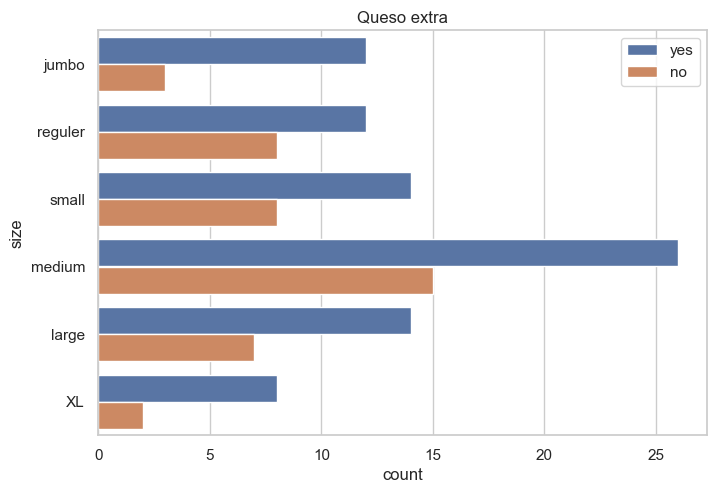

In [45]:
#topping with extra cheese
fig=plt.figure(figsize=(7,5))
sns.countplot(data=pizza, y="size", hue="extra_cheese")
plt.title("Queso extra")
plt.legend(loc="upper right")
plt.show()

Todos los tamaños se prefieren con queso extra.

### Relación entre dos variables

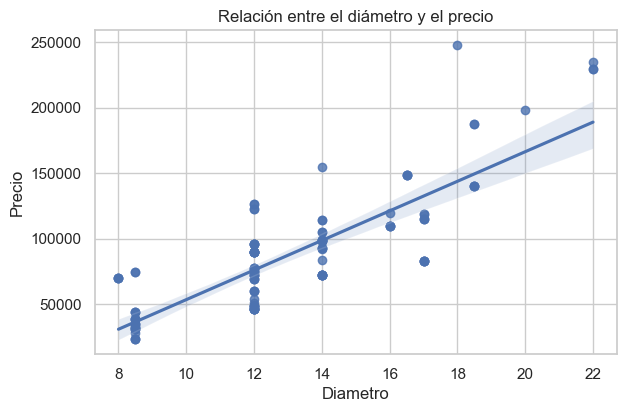

In [46]:
#Verificar la correlación entre 'price' y 'diameter
fig=plt.figure(figsize=(6,4))
sns.regplot(x="diameter", y="price", data=pizza)
plt.title("Relación entre el diámetro y el precio")
plt.xlabel("Diametro")
plt.ylabel("Precio")
plt.show()

Hay una relación lineal entre el precio y el diámetro.

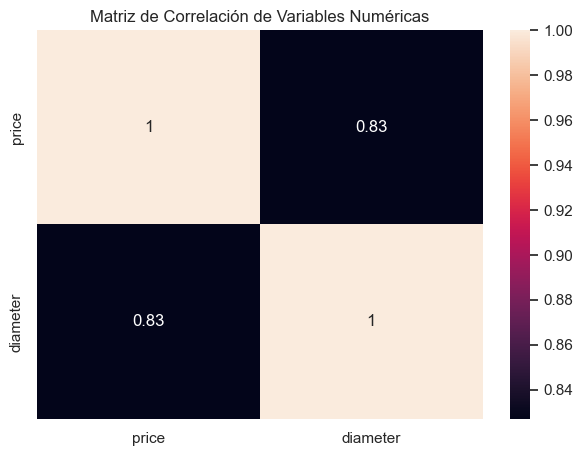

In [47]:
sns.heatmap(pizza.corr(), annot=True)
plt.title("Matriz de Correlación de Variables Numéricas")

# Agregar cualquier otro ajuste o personalización del gráfico si es necesario
plt.show()

In [48]:
# convertimos las variables categoricas a numericas
from sklearn.preprocessing import LabelEncoder 

encoder = LabelEncoder() 

for i in pizza.columns:
    if pizza[i].dtype == 'object': 
        encoder.fit_transform(list(pizza[i].values))
        pizza[i] = encoder.transform(pizza[i].values) 
         
        for j in pizza.columns:
            if pizza[j].dtype == 'int':
                pizza[j] = pizza[j].astype('float64') 

Mostramos la correlación entre todas las variables

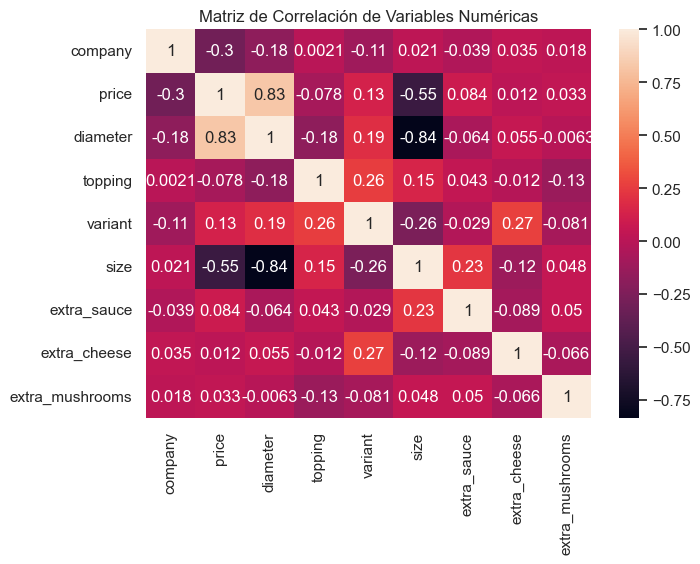

In [49]:
sns.heatmap(pizza.corr(), annot=True)
plt.title("Matriz de Correlación de Variables Numéricas")

# Agregar cualquier otro ajuste o personalización del gráfico si es necesario
plt.show()

Relación positiva (precio vs diámetro = 0.83): Esta es una relación positiva, lo que significa que ambas variables tienden a aumentar juntas. En otras palabras, cuando aumenta el diámetro de la pizza, el precio también tiende a aumentar, y viceversa.

Relación negativa: En una relación negativa, los valores de una variable tienden a aumentar mientras que los de la otra tienden a disminuir. Por ejemplo, si el precio aumenta, el tamaño (size) tiende a disminuir.

### Modelos de Regresión

#### Particionar tabla

In [50]:
#Variables en el modelo
X = pizza.drop(["price"], axis=1)# todoas las variables menos la variable precio
y = pizza["price"]

X.shape, y.shape

((129, 8), (129,))

In [51]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from sklearn.ensemble import  RandomForestRegressor

# vamos a utilizar el 70% de los datos para entrenar el modelo y un 30% para probar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Random Forest Regressor

In [52]:
model_rf = RandomForestRegressor(random_state=42)
# entrenamiento
model_rf.fit(X_train, y_train)
#predicción
pred_rf = model_rf.predict(X_test)


In [53]:
print('Testing R2 Score: ', r2_score(y_test, pred_rf)*100)
print('Testing RMSE: ', np.sqrt(mean_squared_error(y_test, pred_rf)))
print('Testing MAE: ', mean_absolute_error(y_test, pred_rf))
print('Testing MSE: ', mean_squared_error(y_test, pred_rf))

Testing R2 Score:  90.49073335663846
Testing RMSE:  17047.635673350193
Testing MAE:  11732.564102564103
Testing MSE:  290621882.05128205


R2 Score (Coeficiente de Determinación): Un valor del 90.49% significa que el modelo explica aproximadamente el 90.49% de la variabilidad en los datos de prueba. Cuanto más cerca de 1, mejor.

RMSE (Error Cuadrático Medio): El modelo tiene un error promedio de aproximadamente 17047.63 unidades en la escala de la variable objetivo.
    
MAE (Error Absoluto Medio): El error promedio absoluto en las predicciones es de alrededor de 11732.56 unidades.
    
MSE (Error Cuadrático Medio): Métrica utilizada para calcular el RMSE.
    
En general, el modelo parece funcionar bien en la predicción de los datos de prueba, con un alto coeficiente de determinación (R2) y errores relativamente bajos (RMSE y MAE).

In [54]:
pred_rf_trn = model_rf.predict(X_train)

In [55]:
print('Training R2 Score: ', r2_score(y_train, pred_rf_trn)*100)
print('Training RMSE: ', np.sqrt(mean_squared_error(y_train, pred_rf_trn)))
print('Training MAE: ', mean_absolute_error(y_train, pred_rf_trn))
print('Training MSE: ', mean_squared_error(y_train, pred_rf_trn))

Training R2 Score:  97.76498631624091
Training RMSE:  5822.953336199385
Training MAE:  4285.444444444444
Training MSE:  33906785.55555555


R2 Score (Coeficiente de Determinación): Un valor del 97.76% indica que el modelo explica aproximadamente el 97.76% de la variabilidad en los datos de entrenamiento. Esto sugiere un buen ajuste del modelo a los datos de entrenamiento.

RMSE (Error Cuadrático Medio): El error promedio en las predicciones del modelo en los datos de entrenamiento es de aproximadamente 5822.95 unidades en la escala de la variable objetivo.

MAE (Error Absoluto Medio): El error promedio absoluto en las predicciones del modelo en los datos de entrenamiento es de aproximadamente 5055.29 unidades.

MSE (Error Cuadrático Medio): Métrica utilizada para calcular el RMSE en los datos de entrenamiento.

En resumen, el modelo parece tener un buen rendimiento en los datos de entrenamiento, con un alto coeficiente de determinación y errores relativamente bajos.

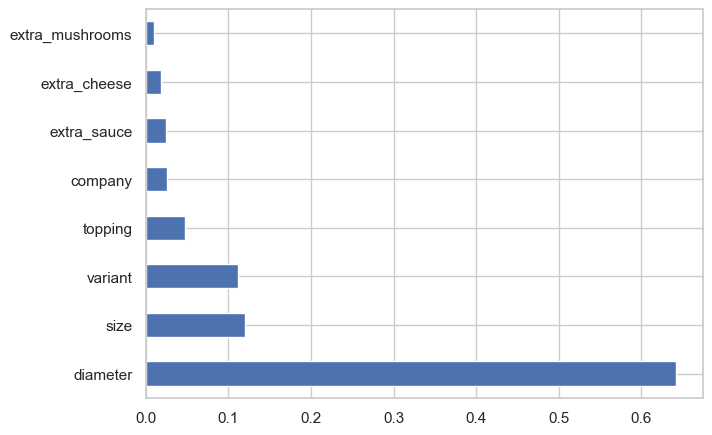

In [56]:
#Graficamos la variable de mayor importancia del modelo Random Forest Regressor
feat_importances_rf = pd.Series(model_rf.feature_importances_, index=X.columns)
feat_importances_rf.nlargest(10).plot(kind='barh')
plt.show()

Podemos observar en el gráfico que la variable de mayor importancia para nuestro modelo es el diametro

#### Regresión XGBoost 

In [57]:
from xgboost import XGBRFRegressor

In [58]:
# creamos objeto de XGBoost
model_xgb = XGBRFRegressor(max_depth=8, n_estimators = 10)
model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_test)

In [59]:
print('Testing R2 Score: ', r2_score(y_test, pred_xgb)*100)
print('Testing RMSE: ', np.sqrt(mean_squared_error(y_test, pred_xgb)))
print('Testing MAE: ', mean_absolute_error(y_test, pred_xgb))
print('Testing MSE: ', mean_squared_error(y_test, pred_xgb))

Testing R2 Score:  85.6733123054799
Testing RMSE:  20924.90715675065
Testing MAE:  11556.84400040064
Testing MSE:  437851739.5186346


R2 Score (Coeficiente de Determinación): Un valor del 85.67% indica que el modelo explica aproximadamente el 85.67% de la variabilidad en los datos de prueba. Esto sugiere un buen ajuste del modelo a los datos de prueba, aunque es ligeramente inferior al rendimiento en los datos de entrenamiento.

RMSE (Error Cuadrático Medio): El error promedio en las predicciones del modelo en los datos de prueba es de aproximadamente 20924.90 unidades en la escala de la variable objetivo.

MAE (Error Absoluto Medio): El error promedio absoluto en las predicciones del modelo en los datos de prueba es de aproximadamente 11556.84 unidades.

MSE (Error Cuadrático Medio): Métrica utilizada para calcular el RMSE en los datos de prueba.

En resumen, el modelo muestra un buen rendimiento en los datos de prueba, con un coeficiente de determinación razonablemente alto y errores de predicción aceptables.

In [60]:
pred_xgb_trn = model_xgb.predict(X_train)

In [61]:
print('Training R2 Score: ', r2_score(y_train, pred_xgb_trn)*100)
print('Training RMSE: ', np.sqrt(mean_squared_error(y_train, pred_xgb_trn)))
print('Training MAE: ', mean_absolute_error(y_train, pred_xgb_trn))
print('Training MSE: ', mean_squared_error(y_train, pred_xgb_trn))

Training R2 Score:  98.36723049069768
Training RMSE:  4976.977271131923
Training MAE:  3347.666948784722
Training MSE:  24770302.757363763


R2 Score (Coeficiente de Determinación): El modelo tiene un puntaje R2 de aproximadamente 98.36% en el conjunto de entrenamiento. Esto indica que el 98.36% de la variabilidad en los datos de entrenamiento se explica utilizando el modelo, lo que sugiere un ajuste muy bueno.

RMSE (Error Cuadrático Medio): El error promedio en las predicciones del modelo en el conjunto de entrenamiento es de aproximadamente 4976.97 unidades en la escala de la variable objetivo.

MAE (Error Absoluto Medio): El error promedio absoluto en las predicciones del modelo en el conjunto de entrenamiento es de aproximadamente 3347.66 unidades.

MSE (Error Cuadrático Medio): Métrica utilizada para calcular el RMSE en el conjunto de entrenamiento.

Estas métricas indican que el modelo se ajusta muy bien a los datos de entrenamiento y tiene un alto poder predictivo.

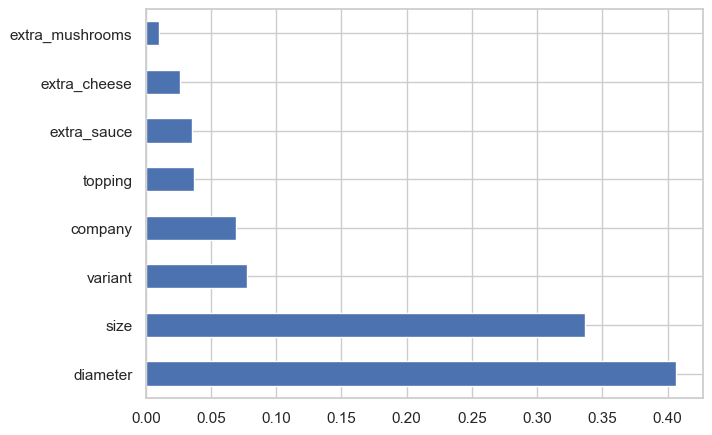

In [62]:
#Graficamos la variable de mayor importancia del modelo XGBoost
feat_importances_xbg = pd.Series(model_xgb.feature_importances_, index=X.columns)
feat_importances_xbg.nlargest(10).plot(kind='barh')
plt.show()

#### Árbol de decisión

In [63]:
from sklearn.tree import DecisionTreeRegressor

In [64]:
# Creando objeto de Regreción de Árbol de Decisión
model_dt = DecisionTreeRegressor()
model_dt.fit(X_train, y_train)
pred_dt = model_dt.predict(X_test)

In [65]:
print('Testing R2 Score: ', r2_score(y_test, pred_dt)*100)
print('Testing RMSE: ', np.sqrt(mean_squared_error(y_test, pred_dt)))
print('Testing MAE: ', mean_absolute_error(y_test, pred_dt))
print('Testing MSE: ', mean_squared_error(y_test, pred_dt))

Testing R2 Score:  94.17513808291966
Testing RMSE:  13342.38474820865
Testing MAE:  7294.871794871795
Testing MSE:  178019230.76923078


Estas métricas indican que el modelo también tiene un buen rendimiento en el conjunto de prueba, lo que sugiere que es capaz de generalizar bien a nuevos datos. El R2 Score es un indicativo de que el modelo tiene una buena capacidad para explicar la variabilidad en los datos de prueba.

In [66]:
pred_dt_trn = model_dt.predict(X_train)

In [67]:
print('Training R2 Score: ', r2_score(y_train, pred_dt_trn)*100)
print('Training RMSE: ', np.sqrt(mean_squared_error(y_train, pred_dt_trn)))
print('Training MAE: ', mean_absolute_error(y_train, pred_dt_trn))
print('Training MSE: ', mean_squared_error(y_train, pred_dt_trn))

Training R2 Score:  100.0
Training RMSE:  0.0
Training MAE:  0.0
Training MSE:  0.0


R2 Score (Coeficiente de Determinación): El modelo tiene un puntaje R2 de aproximadamente 100% en el conjunto de entrenamiento. Esto indica que el 100% de la variabilidad en los datos de entrenamiento se explica utilizando el modelo, lo que sugiere un excelente ajuste y capacidad predictiva en este conjunto de datos de entrenamiento.

RMSE (Error Cuadrático Medio): El error promedio en las predicciones del modelo en el conjunto de entrenamiento es de aproximadamente 0.0 unidades en la escala de la variable objetivo. Este valor es relativamente bajo, lo que indica que el modelo tiene un buen ajuste a los datos de entrenamiento.

MAE (Error Absoluto Medio): El error promedio absoluto en las predicciones del modelo en el conjunto de entrenamiento es de aproximadamente 0.0 unidades. Esto sugiere que las predicciones del modelo tienden a estar bastante cerca de los valores reales en el conjunto de entrenamiento.

MSE (Error Cuadrático Medio): Métrica utilizada para calcular el RMSE en el conjunto de entrenamiento.

En resumen, las métricas de rendimiento en el conjunto de entrenamiento son excepcionales, lo que indica que el modelo se ajusta muy bien a estos datos de entrenamiento y es capaz de explicar la mayoría de la variabilidad en los mismos. Sin embargo, es importante verificar cómo se desempeña en un conjunto de prueba independiente para evaluar su capacidad de generalización.

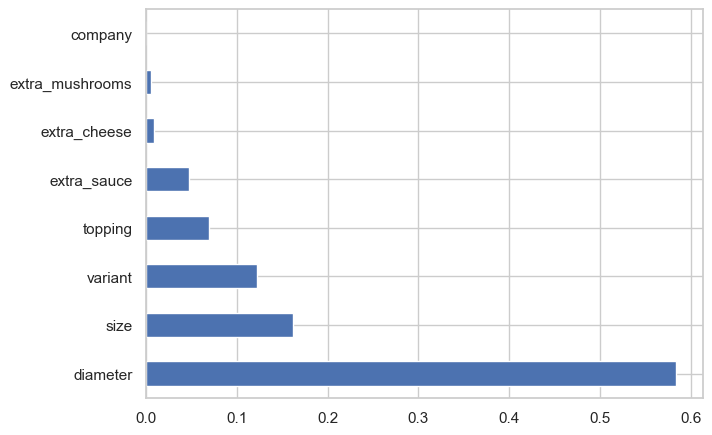

In [68]:
feat_importances_dt = pd.Series(model_dt.feature_importances_, index=X.columns)
feat_importances_dt.nlargest(10).plot(kind='barh')
plt.show()

In [69]:
modelos = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Arbol Decisión'],
    'R2-Test': [r2_score(y_test, pred_xgb)*100, r2_score(y_test, pred_xgb)*100, r2_score(y_test, pred_dt)*100],
    'RMSE-Test': [np.sqrt(mean_squared_error(y_test, pred_rf)), np.sqrt(mean_squared_error(y_test, pred_xgb)), np.sqrt(mean_squared_error(y_test, pred_rf)) ],
}
)
modelos

Model    R2-Test     RMSE-Test
0   Random Forest  85.673312  17047.635673
1         XGBoost  85.673312  20924.907157
2  Arbol Decisión  94.175138  17047.635673

El modelo de Árbol de Decisión tiene el mejor R2-Test, lo que sugiere un buen ajuste a los datos de prueba. Sin embargo, comparte el mismo RMSE-Test que el modelo Random Forest, lo que indica un error similar en las predicciones del conjunto de prueba. El modelo XGBoost tiene un rendimiento ligeramente inferior en comparación con los otros dos modelos en estas métricas.

En resumen, el Árbol de Decisión parece ser la mejor opción en términos de R2-Test

#### Realizamos una prueba de nuestro modelo

In [70]:
prueba=pd.DataFrame({'company':[2,1],'diameter':[14,12], 'topping':[8,2], 'variant':[1,5], 
    'size':[5,3], 'extra_sauce':[0,0], 'extra_cheese':[1,0],'extra_mushrooms':[1,0]})
prueba

company  diameter  topping  variant  size  extra_sauce  extra_cheese  \
0        2        14        8        1     5            0             1   
1        1        12        2        5     3            0             0   

   extra_mushrooms  
0                1  
1                0

In [71]:
print(model_xgb.predict(prueba))

[97699.92 61960.14]


In [72]:
pizza['price'].describe()

count       129.000000
mean      87151.162791
std       44706.097732
min       23500.000000
25%       51000.000000
50%       78000.000000
75%      105000.000000
max      248000.000000
Name: price, dtype: float64

En general, los valores predichos por el modelo están en línea con la distribución de los precios reales, con algunos valores más altos y otros más bajos. El modelo parece capturar cierta variabilidad en los precios reales, pero también hay diferencias entre las predicciones y los valores reales.

## Geoespacial

In [73]:
# URL del servicio WFS que deseas consultar
wfs_url = "http://ide.pergamino.gob.ar:8080/geoserver/wfs" # IGN

# Solicitud GetCapabilities al servicio WFS
wfs = WebFeatureService(wfs_url, version='1.0.0')

# Listado de capas publicadas
#list(wfs.contents)

### Seleccionamos la variable
En este caso elegimos la variable Gastronomía

In [74]:
# Radios censales de gastronomia
gastronomia = gpd.read_file(wfs.getfeature(typename=['gastronomia']))
gastronomia.head()

gml_id                         nombre                direccion  \
0   gastronomia.1  Helens Guest House Restaurant              Florida 514   
1  gastronomia.40             La Mulita Parrilla     Dr Alem y Pueyrredon   
2   gastronomia.3                      Prudencio   Prudencio Gonzalez 965   
3   gastronomia.4                    Burger Shop              Alberti 378   
4  gastronomia.30         Catalina Parilla Libre  Ruta 8 y José Hernández   

       telefono                        mail  \
0   2477-424752  helensguesthouse@gmail.com   
1  02477-416900                         NaN   
2   2477-413795                         NaN   
3   2477-419688                         NaN   
4   2477-425766                         NaN   

                                                 web         tipo  \
0                        www.helensguesthouse.com.ar  Restaurante   
1                                                NaN  Restaurante   
2                                                NaN  Restaurante   
3  https://www.facebook.com/burgershoppergamino?f...  Restaurante   
4                                                NaN  Restaurante   

  observaciones instagram                     geometry  
0           NaN       NaN  POINT (-60.57349 -33.89803)  
1           NaN       NaN  POINT (-60.57157 -33.89446)  
2           NaN       NaN  POINT (-60.56600 -33.90033)  
3           NaN       NaN  POINT (-60.56897 -33.89372)  
4           NaN       NaN  POINT (-60.55261 -33.89976)

In [75]:
# Gastronomia
gastronomia = gpd.read_file(wfs.getfeature(typename=['gastronomia']))
# Verificamos si tiene crs asociados
print(gastronomia.crs)

None


#### Seteamos la columna geometry

Al no tener crs asociados ajustamos la proyección de los datos geoespaciales primero al sistema de referencia global (WGS 84) y luego a una proyección local específica (Gauss-Krüger Faja 5) para que coincidan con la región de interés y se puedan realizar análisis geoespaciales precisos en esa área.

In [76]:
# WGS84 - Seteo
gastronomia = gastronomia.set_crs('EPSG:4326') 

# Se transforma a Gauss Kruger Faja 5 para trabajar en un sistema proyectado ()
gastronomia = gastronomia.to_crs('EPSG:5347')

In [77]:
gastronomia.head()

gml_id                         nombre                direccion  \
0   gastronomia.1  Helens Guest House Restaurant              Florida 514   
1  gastronomia.40             La Mulita Parrilla     Dr Alem y Pueyrredon   
2   gastronomia.3                      Prudencio   Prudencio Gonzalez 965   
3   gastronomia.4                    Burger Shop              Alberti 378   
4  gastronomia.30         Catalina Parilla Libre  Ruta 8 y José Hernández   

       telefono                        mail  \
0   2477-424752  helensguesthouse@gmail.com   
1  02477-416900                         NaN   
2   2477-413795                         NaN   
3   2477-419688                         NaN   
4   2477-425766                         NaN   

                                                 web         tipo  \
0                        www.helensguesthouse.com.ar  Restaurante   
1                                                NaN  Restaurante   
2                                                NaN  Restaurante   
3  https://www.facebook.com/burgershoppergamino?f...  Restaurante   
4                                                NaN  Restaurante   

  observaciones instagram                         geometry  
0           NaN       NaN  POINT (5446954.991 6249467.135)  
1           NaN       NaN  POINT (5447130.585 6249864.436)  
2           NaN       NaN  POINT (5447648.975 6249216.586)  
3           NaN       NaN  POINT (5447369.907 6249947.413)  
4           NaN       NaN  POINT (5448887.243 6249286.141)

In [78]:
mapa = gastronomia.explore(
    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.5),  # Opacidad de relleno
    name="gastronomia",  # Nombre del layer en el control de capas
)

mapa # Mostrar mapa de los lugares gastronomicos

Realizamos un buffer de 300 metros sobre los centros gastronómicos para conocer su área de influencia

In [79]:
# Creación del buffer
# Radio de influencia en unidades del sistema de coordenadas de la capa la cual la trabajamos en metros
gastronomia_buffer = gastronomia.buffer(300) 

# Comprobación del objeto resultado
gastronomia_buffer.head()

0    POLYGON ((5447254.991 6249467.135, 5447253.546...
1    POLYGON ((5447430.585 6249864.436, 5447429.140...
2    POLYGON ((5447948.975 6249216.586, 5447947.530...
3    POLYGON ((5447669.907 6249947.413, 5447668.463...
4    POLYGON ((5449187.243 6249286.141, 5449185.798...
dtype: geometry

In [80]:
# Conversión en un GeoDataFrame
# Indicamos
gastronomia_buffer = gpd.GeoDataFrame(geometry=gastronomia_buffer, crs=gastronomia.crs) 

In [81]:
mapa = gastronomia_buffer.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Área Influencia",  # Nombre del layer en el control de capas
)

folium.LayerControl().add_to(mapa)  # Agregar control de capas al mapa

mapa # Mostrar mapa

### Disolver
Este algoritmo toma una capa vectorial de polígonos y borrará los límites comunes de los polígonos adyacentes. Se pueden especificar uno o más atributos para disolver características pertenecientes a la misma clase (con el mismo valor para los atributos especificados), o bien todos los objetos espaciales se pueden disolver en uno solo.

Apliquemos este algoritmos sobre el área de influencia.

In [82]:
# Aplicamos un disolver sin agrupamiento por columna
gastronomia_dissolve = gastronomia_buffer.dissolve()

# Comprobación del objeto resultado
gastronomia_dissolve

geometry
0  MULTIPOLYGON (((5445884.291 6247142.531, 54458...

In [83]:
mapa = gastronomia_dissolve.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Área Influencia Disuelta",  # Nombre del layer en el control de capas
)

mapa # Mostrar mapa

### Polígonos de Voronoi

Aplicaremos esta transformación para conocer el centro gastronómico más cercano de acuerdo a la ubicación.

In [84]:
# Extraemos coordenadas X e Y de la geometría porque es la forma que lo requiere scipy.spatial
x_coords = gastronomia.geometry.x
y_coords = gastronomia.geometry.y

# Creamos un DataFrame con las coordenadas
coords_gastronomia = pd.DataFrame({'X': x_coords, 'Y': y_coords})

# Creamos polígonos de Voronoi
vor = Voronoi(coords_gastronomia)

# Capturamos los vertices de cada polígono
voronoi_polygons = []
for region in vor.regions:
    if not -1 in region and len(region) > 0:
        vertices = [vor.vertices[i] for i in region]
        voronoi_polygons.append(Polygon(vertices))

# Creamos un GeoDataFrame con los polígonos de Voronoi
poligonos_voronoi = gpd.GeoDataFrame(geometry=voronoi_polygons)
poligonos_voronoi = poligonos_voronoi.set_crs(gastronomia.crs) # Utilizamos la capa que le da origen

# Mostramos el GeoDataFrame resultante
mapa = poligonos_voronoi.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Área Influencia Disuelta",  # Nombre del layer en el control de capas
)

mapa # Mostrar mapa

### Cortar
Cortamos los polígonos de Voronoi con el área de influencia para enmarcar nuestro problema al área de estudio con el método `overlay`.

In [85]:
# Cortamos la capa Voronoi con el área de influencia disuelta
resultado_corte = gpd.overlay(poligonos_voronoi, gastronomia_dissolve, how='intersection')

# Mostramos el GeoDataFrame resultante
mapa = resultado_corte.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Área Influencia Disuelta",  # Nombre del layer en el control de capas
)

gastronomia.explore(
    m=mapa,  # pass the map object
    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'blue', # Color de borde
                    fillColor='blue', # Color de relleno
                    fillOpacity=0.5),  # Opacidad de relleno
    name="gastronomia",  # Nombre del layer en el control de capas
)

folium.LayerControl().add_to(mapa)  # use folium to add layer control

mapa # Mostrar mapa

### Centroides

Cargamos los datos geoespaciales de los barrios, calculamos los centroides de los barrios y luego lo  mostramos en un mapa interactivo con opciones para mostrar u ocultar las capas de los barrios y los centroides. Los barrios se muestran en rojo y los centroides en negro.

In [86]:
# Barrios
barrios = gpd.read_file(wfs.getfeature(typename=['barrios']))
barrios = barrios.set_crs('EPSG:5347') # Se comprobó que no tenía CRS asignado, se verificaron las coordenadas y se asigna Gauss-Kruguer Faja 5 para tener un sistema proyectado

# Calculos de centroides
barrios_centroides = barrios.geometry.centroid

# Mostramos el GeoDataFrame resultante
mapa = barrios.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Barrios",  # Nombre del layer en el control de capas
)

barrios_centroides.explore(
    m=mapa,  # pass the map object
    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'black', # Color de borde
                    fillColor='black', # Color de relleno
                    fillOpacity=0.5),  # Opacidad de relleno
    name="Centroide",  # Nombre del layer en el control de capas
)

folium.LayerControl().add_to(mapa)  # use folium to add layer control

mapa # Mostrar mapa

## Combinaciones

### Unión 1 a 1
Este algoritmo toma una capa vectorial de entrada y crea una nueva capa que contiene los atributos de la capa original junto a los atributos de los objetos superpuestos. Los atributos adicionales y sus valores se toman de una segunda capa vectorial. Se aplica un criterio espacial para seleccionar los valores de la segunda capa que se agregan a cada entidad de la primera capa.

In [87]:
# Realizar la unión espacial por superposición (contención)
union_1a1 = resultado_corte.sjoin(gastronomia, how="inner", predicate='contains')

# Mostramos el GeoDataFrame resultante
mapa = union_1a1.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Área Influencia Disuelta",  # Nombre del layer en el control de capas
)

mapa # Mostrar mapa

Cuando realizamos uniones, existe la posibilidad que muchos elementos de la capa a unir cumplan con el predicado geométrico establecido. En ese caso, la herramienta calcula un resumen estadístico de los atributos de los objetos coincidentes en la segunda capa (por ejemplo, valor máximo, valor medio, etc.).

En nuestro caso contaremos el número de centros gastronómicos por barrio.

In [88]:
# Mostramos el GeoDataFrame resultante
mapa = barrios.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Barrios",  # Nombre del layer en el control de capas
)

gastronomia.explore(
    m=mapa,  # pass the map object
    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'blue', # Color de borde
                    fillColor='blue', # Color de relleno
                    fillOpacity=0.5),  # Opacidad de relleno
    name="Gastronomia",  # Nombre del layer en el control de capas
)

folium.LayerControl().add_to(mapa)  # use folium to add layer control

mapa # Mostrar mapa

In [89]:
# Realizar la unión espacial por superposición (contención)
union = barrios.sjoin(gastronomia, how='inner', predicate='contains')
union.head()

gml_id_left  id nombre_left tipo_left    area  \
0  barrios.fid--2e0e67b8_18b08245369_-7c3   1      Centro   Abierto  222.25   
0  barrios.fid--2e0e67b8_18b08245369_-7c3   1      Centro   Abierto  222.25   
0  barrios.fid--2e0e67b8_18b08245369_-7c3   1      Centro   Abierto  222.25   
0  barrios.fid--2e0e67b8_18b08245369_-7c3   1      Centro   Abierto  222.25   
0  barrios.fid--2e0e67b8_18b08245369_-7c3   1      Centro   Abierto  222.25   

  ordenanza                            delimitacion distrito  \
0   8850-18  Alsina, Colón, Arroyo Pergamino, Rocha   centro   
0   8850-18  Alsina, Colón, Arroyo Pergamino, Rocha   centro   
0   8850-18  Alsina, Colón, Arroyo Pergamino, Rocha   centro   
0   8850-18  Alsina, Colón, Arroyo Pergamino, Rocha   centro   
0   8850-18  Alsina, Colón, Arroyo Pergamino, Rocha   centro   

   proy_habitantes_2020  proy_densidad_2020  ...  index_right  \
0                 15204               68.41  ...          125   
0                 15204               68.41  ...          131   
0                 15204               68.41  ...           76   
0                 15204               68.41  ...           48   
0                 15204               68.41  ...           41   

      gml_id_right           nombre_right             direccion     telefono  \
0  gastronomia.128                  La Fe      San Nicolás 1201       414308   
0  gastronomia.134                  Lilos         Dr. Alem 1001       444144   
0   gastronomia.79             Dry Tragos       General Paz 638  2477-531513   
0   gastronomia.39              Bar Fidel       General Paz 631  2477-444005   
0   gastronomia.49  Taco de Reina Vintage  11 de Septiembre 352  2477-414702   

  mail  web   tipo_right observaciones  \
0  NaN  NaN    Heladeria           NaN   
0  NaN  NaN    Heladeria           NaN   
0  NaN  NaN    Resto-bar           NaN   
0  NaN  NaN    Resto-bar           NaN   
0  NaN  NaN  Restaurante           NaN   

                                           instagram  
0  helaadoslafe                                  ...  
0  lilos.artesanal                               ...  
0                                                NaN  
0                                                NaN  
0                                                NaN  

[5 rows x 23 columns]

El resultado es un nuevo conjunto de datos que muestra la relación entre los barrios y los lugares gastronómicos en términos de superposición espacial. La salida es un DataFrame que contiene información sobre los barrios y los lugares gastronómicos que están contenidos dentro de cada barrio. Cada fila de este DataFrame representa una unión entre un barrio y un lugar gastronómico.

## Conteo

Realizamos un conteo de la cantidad de lugares gastronómicos por barrio y luego fusiona esta información con el GeoDataFrame de los barrios en Pergamino.

In [90]:
# Agrupamos la tabla de unión por el identificador único del barrio
conteo_por_barrio = union.groupby('id').size().reset_index(name='cantidad_gastronomia') #Size devuelve el numero de filas (Pandas)

# Fusionar el recuento con el GeoDataFrame de barrios
barrios = barrios.merge(conteo_por_barrio, on='id', how='left')
barrios.head()

gml_id  id               nombre     tipo  \
0  barrios.fid--2e0e67b8_18b08245369_-7c3   1               Centro  Abierto   
1  barrios.fid--2e0e67b8_18b08245369_-7c2  18              Kennedy  Abierto   
2  barrios.fid--2e0e67b8_18b08245369_-7c1   5               Trocha  Abierto   
3  barrios.fid--2e0e67b8_18b08245369_-7c0  22     María Crescencia  Abierto   
4  barrios.fid--2e0e67b8_18b08245369_-7bf  36  Martín M. de Güemes  Abierto   

     area ordenanza                                       delimitacion  \
0  222.25   8850-18             Alsina, Colón, Arroyo Pergamino, Rocha   
1   87.32   8850-18  Arroyo Pergamino, Dr Balbín, Dr. F. Auil, Fron...   
2   37.90   8850-18  Yrigoyen, Rocha, Arroyo Pergamino, vías FFCC e...   
3   63.53   8850-18  Tropero Chavero, Hernández, límite sur parcela...   
4   75.26   8850-18  Esquivel, vías FFCC ex Mitre, Arroyo Pergamino...   

  distrito  proy_habitantes_2020  proy_densidad_2020  color_id  localidad  \
0   centro                 15204               68.41         3  Pergamino   
1      sur                  1440               16.49         7  Pergamino   
2     este                  2209               58.28         4  Pergamino   
3     este                   433                6.82         1  Pergamino   
4    oeste                  1433               19.04         3  Pergamino   

                                            geometry  cantidad_gastronomia  
0  MULTIPOLYGON (((5445892.146 6249178.833, 54459...                  85.0  
1  MULTIPOLYGON (((5447894.022 6248360.572, 54479...                   NaN  
2  MULTIPOLYGON (((5447676.723 6249783.332, 54480...                   7.0  
3  MULTIPOLYGON (((5448899.657 6248695.493, 54495...                   NaN  
4  MULTIPOLYGON (((5445388.914 6249467.632, 54452...                   NaN

In [91]:
# Mostramos el GeoDataFrame resultante
mapa = barrios.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Barrios",  # Nombre del layer en el control de capas
)

gastronomia.explore(
    m=mapa,  # pass the map object
    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'blue', # Color de borde
                    fillColor='blue', # Color de relleno
                    fillOpacity=0.5),  # Opacidad de relleno
    name="gastronomia",  # Nombre del layer en el control de capas
)

folium.LayerControl().add_to(mapa)  # use folium to add layer control

mapa # Mostrar mapa

In [92]:
# Completamos los datos faltantes en la columna 'cantidad_gastronomia' con 0
barrios['cantidad_gastronomia'].fillna(0, inplace=True)

## Cálculo de distancias

Realizamos un cálculo de distancias entre los barrios de Pergamino y los cursos de agua más cercanos.
El resultado de este análisis es la distancia entre los objetos más cercanos de 2 capas.

In [93]:
# Cursos de agua
cursos_de_agua = gpd.read_file(wfs.getfeature(typename=['cursos_de_agua']))
cursos_de_agua = cursos_de_agua.set_crs('EPSG:5347') # Se comprobó que no tenía CRS asignado, se verificaron las coordenadas y se asigna Gauss-Kruguer Faja 5 para tener un sistema proyectado

from shapely.ops import nearest_points
# Crear una lista para almacenar las distancias al río más cercano
distancias_al_rio = []

# Iterar sobre los barrios y calcular la distancia al río más cercano
for idx, barrio in barrios.iterrows():
    punto_barrio = barrio.geometry.centroid
    punto_mas_cercano = nearest_points(punto_barrio, cursos_de_agua.unary_union)[1]
    distancia = punto_barrio.distance(punto_mas_cercano)
    distancias_al_rio.append(distancia)

# Agregar la lista de distancias al GeoDataFrame de barrios
barrios['distancia_al_rio_mas_cercano'] = distancias_al_rio

In [94]:
# Mostramos el GeoDataFrame resultante
mapa = barrios.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Barrios",  # Nombre del layer en el control de capas
)

barrios_centroides.explore(
    m=mapa,  # pass the map object
    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'black', # Color de borde
                    fillColor='black', # Color de relleno
                    fillOpacity=0.5),  # Opacidad de relleno
    name="Centroide",  # Nombre del layer en el control de capas
)

cursos_de_agua.explore(
    m=mapa,  # pass the map object
    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=2, # Grosor en px del borde
                    color = 'blue'), # Color de borde
    name="Curso de agua",  # Nombre del layer en el control de capas
)

folium.LayerControl().add_to(mapa)  # use folium to add layer control

mapa # Mostrar mapa

## Censo 2010

In [95]:
#Carga de datos
url = 'https://raw.githubusercontent.com/Marian2057/TP-Geoespacial/main/Indicadores_de_hogares_Radios.csv'
df = pd.read_csv(url)
df.head()

Código de radio.  Total de hogares  Hogares con al menos un indicador NBI  \
0          66230601                 4                                      0   
1          66230602                10                                      0   
2          66230703                22                                      3   
3          66230603                 0                                      0   
4          66230901                20                                      1   

   Hogares con computadora  \
0                        0   
1                        2   
2                        6   
3                        0   
4                       10   

   Hogares con una o más personas de servicio doméstico sin retiro (con cama)  \
0                                                  0                            
1                                                  0                            
2                                                  0                            
3                                                  0                            
4                                                  0                            

   Hogares con hacinamiento (>= 3 personas por cuarto)  Hogares sin heladeras  \
0                                                  0                        0   
1                                                  0                        0   
2                                                  1                        2   
3                                                  0                        0   
4                                                  0                        1   

   Hogares sin sistema de botón, cadena o mochila para limpieza del inodoro.  \
0                                                  0                           
1                                                  0                           
2                                                  4                           
3                                                  0                           
4                                                  0                           

   Hogares sin agua para beber y cocinar proveniente de red pública  \
0                                                  4                  
1                                                 10                  
2                                                 22                  
3                                                  0                  
4                                                 19                  

   Hogares sin cañería de agua en la vivienda  ...  Nombre de provincia  \
0                                           0  ...         Buenos Aires   
1                                           0  ...         Buenos Aires   
2                                           4  ...         Buenos Aires   
3                                           0  ...         Buenos Aires   
4                                           0  ...         Buenos Aires   

   Código de departamentos/comuna  Nombre de departamentos/comuna  \
0                            6623                       Pergamino   
1                            6623                       Pergamino   
2                            6623                       Pergamino   
3                            6623                       Pergamino   
4                            6623                       Pergamino   

   Código de radio  Población total  Total de hogares.1  \
0         66230601                9                   4   
1         66230602               30                  10   
2         66230703               80                  22   
3         66230603                0                   0   
4         66230901               62                  20   

   Latitud del centroide  Longitud del centroide  Superficie en km2  \
0             -33.576819              -60.853516          50.542338   
1             -33.613278              -60.807402          57.132111   
2             -33.639034 

La información geoespacial esta en formato WKT, convertimos esas geometrías en objetos geométricos y creamos un nuevo GeoDataFrame con la proyección especificada como EPSG:4326. Esto nos permite trabajar con datos geoespaciales en la proyección deseada y realizar análisis espaciales o visualizaciones de manera adecuada.

In [109]:
# Específica la proyección EPSG:4326 correctamente
crs = CRS.from_epsg(4326)

# Convierte la columna que contiene la geometría WKT
df["geometry"] = df["Geometría en WKT"].apply(loads)

# Convierte el DataFrame en GeoDataFrame y asigna la proyección
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs=crs)

Repetimos el paso de seteo pero en este caso con la dataframe de las variables del censo 2010

In [97]:
# WGS84 - Seteo
gdf = gdf.set_crs('EPSG:4326') 

# Se transforma a Gauss Kruger Faja 5 para trabajar en un sistema proyectado ()
gdf = gdf.to_crs('EPSG:5347')

## Clusterización con K-means

Paso 0 - Carga y preparación de datos
En este paso unimos los datadrame radios_censales con el dataframe gdf seleccionando las siguientes variables del censo 2010, Hogares con al menos un indicador NBI, Hogares sin agua para beber y cocinar proveniente de red pública, Hogares sin cañería de agua en la vivienda.

In [98]:
# GetFeature y Seteo de CRS
radios_censales = gpd.read_file(wfs.getfeature(typename=['radios_censales_indec_2010']))
radios_censales = radios_censales.set_crs('EPSG:5347')

# Realizar la unión de los DataFrames en base a las columnas "radio_id" y "Código de radio."
radios_censales = radios_censales.merge(gdf[['Código de radio.', 'Hogares con al menos un indicador NBI',
                                      'Hogares sin agua para beber y cocinar proveniente de red pública',
                                      'Hogares sin cañería de agua en la vivienda']], 
                                  left_on='radio_id', right_on='Código de radio.', how='inner')

# Normalizar las variables
#scaler = StandardScaler()
#radios_censales = scaler.fit_transform(radios_censales)

radios_censales.head()

gml_id       clavera   radio-id  varon  mujer  \
0  radios_censales_indec_2010.3  066231000301  066230301    233    267   
1  radios_censales_indec_2010.4  066231000308  066230308    234    331   
2  radios_censales_indec_2010.5  066230000601  066230601      4      5   
3  radios_censales_indec_2010.6  066230000602  066230602     17     13   
4  radios_censales_indec_2010.7  066230000904  066230904     38     24   

   hab_2010  radio_id      fuente actualizacion  \
0       500  66230301  INDEC 2010          2016   
1       565  66230308  INDEC 2010          2016   
2         9  66230601  INDEC 2010          2016   
3        30  66230602  INDEC 2010          2016   
4        62  66230904  INDEC 2010          2016   

                                            geometry  Código de radio.  \
0  POLYGON ((5446235.333 6250570.066, 5446324.284...          66230301   
1  POLYGON ((5447556.668 6249828.883, 5447516.477...          66230308   
2  POLYGON ((5424098.301 6288857.555, 5424168.801...          66230601   
3  POLYGON ((5426720.301 6285501.555, 5426910.301...          66230602   
4  POLYGON ((5467694.473 6275306.261, 5469688.468...          66230904   

   Hogares con al menos un indicador NBI  \
0                                      1   
1                                      2   
2                                      0   
3                                      0   
4                                      0   

   Hogares sin agua para beber y cocinar proveniente de red pública  \
0                                                  1                  
1                                                  0                  
2                                                  4                  
3                                                 10                  
4                                                 28                  

   Hogares sin cañería de agua en la vivienda  
0                                           0  
1                                           1  
2                                           0  
3                                           0  
4                                           0

<Axes: >

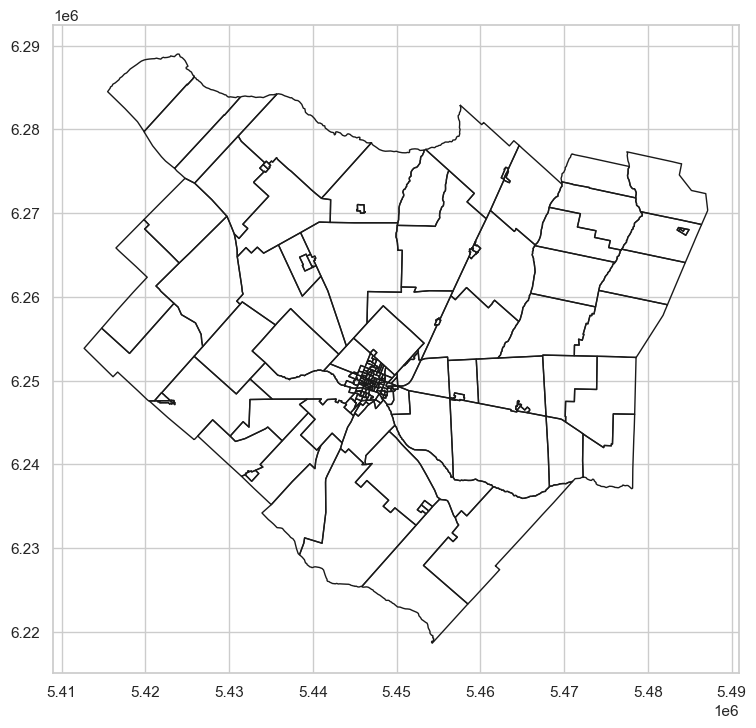

In [99]:
# Elimino todas las variables excepto su geometría
radios_censales = radios_censales[['geometry']]


# Muestra visualización simple
radios_censales.plot(edgecolor='k', facecolor='none', figsize=(10, 8))

In [100]:
radios_censales

geometry
0    POLYGON ((5446235.333 6250570.066, 5446324.284...
1    POLYGON ((5447556.668 6249828.883, 5447516.477...
2    POLYGON ((5424098.301 6288857.555, 5424168.801...
3    POLYGON ((5426720.301 6285501.555, 5426910.301...
4    POLYGON ((5467694.473 6275306.261, 5469688.468...
..                                                 ...
173  POLYGON ((5450151.368 6249147.520, 5450160.012...
174  POLYGON ((5447477.773 6252085.861, 5447441.781...
175  POLYGON ((5446528.492 6250117.809, 5446486.054...
176  POLYGON ((5446621.402 6250736.120, 5446714.442...
177  POLYGON ((5439886.801 6264787.055, 5439915.801...

[178 rows x 1 columns]

#### Paso 1 - Inicialización

Utilizamos K-means para agrupar datos en clústeres y luego mostramos los resultados en un mapa donde se pueden observar los radios censales coloreados por clúster y los centroides de cada clúster en azul. Esto facilita la visualización y comprensión de cómo se agrupan los datos geoespaciales en diferentes clústeres.

<Axes: >

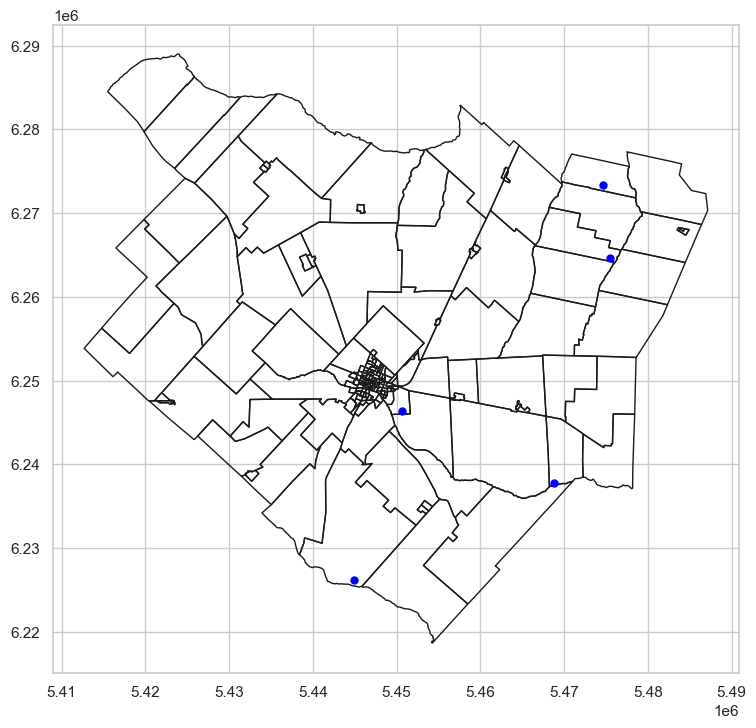

In [101]:
import random

# Cantidad de clúster a formar
num_cluster = 5

# Se generan tantos puntos aleatorios como clúster se quieran crear
## Para ello se establecen límites de radios
limites = radios_censales.total_bounds

## Se genera un listado aleatorio de coordenadas dentro de los límites
puntos_aleatorios = [(random.uniform(limites[0], limites[2]), random.uniform(limites[1], limites[3])) for i in range(num_cluster)]
puntos_aleatorios

## Se crean las geometrías a partir de las coordenadas
from shapely.geometry import Point
geometrias_puntos = [Point(x, y) for x, y in puntos_aleatorios]

## Se crea un GeoDataFrame con las geometrías de punto (centroides de clústers)
centroides_clusters = gpd.GeoDataFrame(geometry=geometrias_puntos, crs=radios_censales.crs)

## Creamos un identificador para cada punto
centroides_clusters['cluster'] = centroides_clusters.index

# Mostramos ambos conjuntos de datos
ax = radios_censales.plot(edgecolor='k', facecolor='none', figsize=(10, 8))
centroides_clusters.plot(ax=ax, color='blue', markersize=25)

In [102]:
centroides_clusters

geometry  cluster
0  POINT (5475466.428 6264593.668)        0
1  POINT (5468749.819 6237730.538)        1
2  POINT (5450703.705 6246358.047)        2
3  POINT (5474581.765 6273340.714)        3
4  POINT (5444945.616 6226216.529)        4

#### Paso 2 - Asignación de Observaciones

Calculamos las distancias entre los radios censales y los centroides de clústeres, luego visualizamos los resultados en un mapa que muestra las conexiones y la asignación de clústeres a cada radio censal.


Text(0.5, 1.0, 'Gráfico 2')

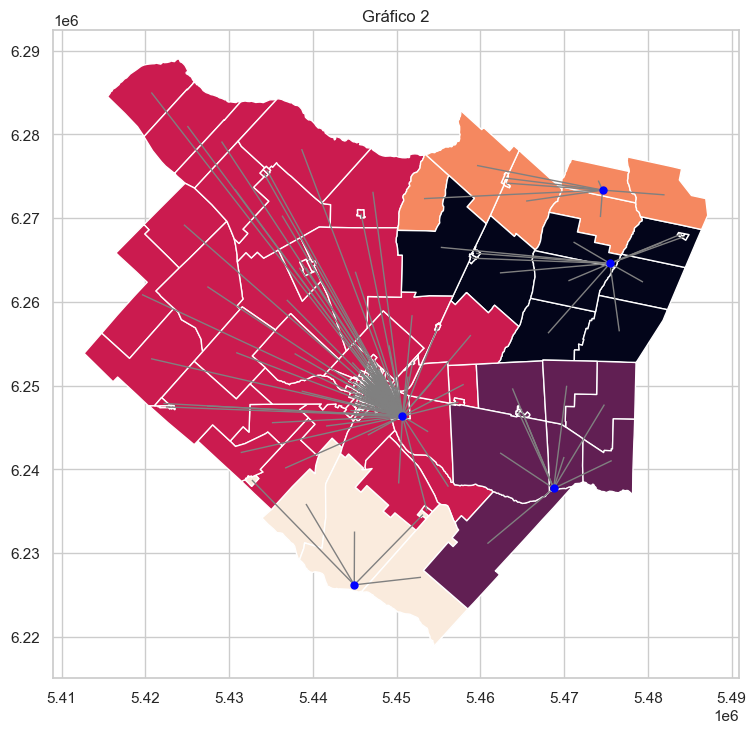

In [103]:
## Reutilizamos el cálculo de distancia de la clase 6 con algunas modificaciones
from shapely.ops import nearest_points
from shapely.geometry import LineString

# Crear una lista para almacenar las distancias al clúster más cercano
conexiones = []

# Iterar sobre los radios_censales y calcular la distancia al clúster más cercano
for idx, radio in radios_censales.iterrows():
    radio_geom = radio.geometry.centroid
    centroide_mas_cercana_idx = nearest_points(radio_geom, centroides_clusters.unary_union)[1]
    centroide_mas_cercana = centroides_clusters[centroides_clusters.geometry == centroide_mas_cercana_idx].iloc[0]
    etiqueta_centroide_cercana = centroide_mas_cercana['cluster']
    radios_censales.at[idx, 'cluster'] = etiqueta_centroide_cercana
    linea_entre_puntos = LineString([radio_geom, centroide_mas_cercana_idx])
    conexiones.append(linea_entre_puntos)

# Convierte la lista de conexiones a un GeoDataFrame para visualizarla
conexiones_gdf = gpd.GeoDataFrame(geometry=conexiones, crs=radios_censales.crs)

# Mostramos ambos conjuntos de datos
# Cambiar los colores
ax = radios_censales.plot(edgecolor='white', column='cluster', figsize=(10, 8), zorder=1)
conexiones_gdf.plot(ax=ax, color='gray', linewidth=1, zorder=1)
centroides_clusters.plot(ax=ax, color='blue', markersize=25, zorder=2)
plt.title('Gráfico 2')

Gráfico paso 2.- Cada color representa a que clúster se unio y cada cluster tiene un color distinto.
Las lineas son las conexiones entre el centroide del radio y el clúster de menor distancia

#### Paso 3 - Actualización de Centroides
Calculamos el promedio de coordenadas de cada clúster para eso podemos utilizar el método `dissolve` .
Gráfico 3.- En este paso K-means hace la actualizacion de centroides desplazando el punto desde la union de todas las lineas hacia el centro de masa de cada polygono. 

In [104]:
# Agrupar por el campo 'cluster' y calculamos el promedio de coordenadas

# En esta linea de codigo lo que haces es dissolve por la variable cluster generando un gran polygono por color
radios_censales_dissolve = radios_censales.dissolve(by='cluster') 
# Calculamos el centroide
reposicion_centroides_clusters = radios_censales_dissolve.centroid 
# lo convertimos en un dataframe
reposicion_centroides_clusters = gpd.GeoDataFrame({'geometry': reposicion_centroides_clusters}, crs=reposicion_centroides_clusters.crs) 


# Realizar una operación de unión 1 a 1 basada en un índice común
centroides_clusters = centroides_clusters.merge(reposicion_centroides_clusters, how='left', on='cluster')
centroides_clusters

geometry_x  cluster                       geometry_y
0  POINT (5475466.428 6264593.668)        0  POINT (5468527.540 6262551.765)
1  POINT (5468749.819 6237730.538)        1  POINT (5466271.292 6241611.849)
2  POINT (5450703.705 6246358.047)        2  POINT (5437382.314 6259775.251)
3  POINT (5474581.765 6273340.714)        3  POINT (5467950.172 6273091.079)
4  POINT (5444945.616 6226216.529)        4  POINT (5446422.855 6231452.239)

Como vemos en la tabla ahora tenemos dos geometrias, geometry_x son las coordenadas originales y 
geometry_y son las nuevas coordenadas indicándonos las nuevas posiciones de los puntos.

Text(0.5, 1.0, 'Gráfico 3')

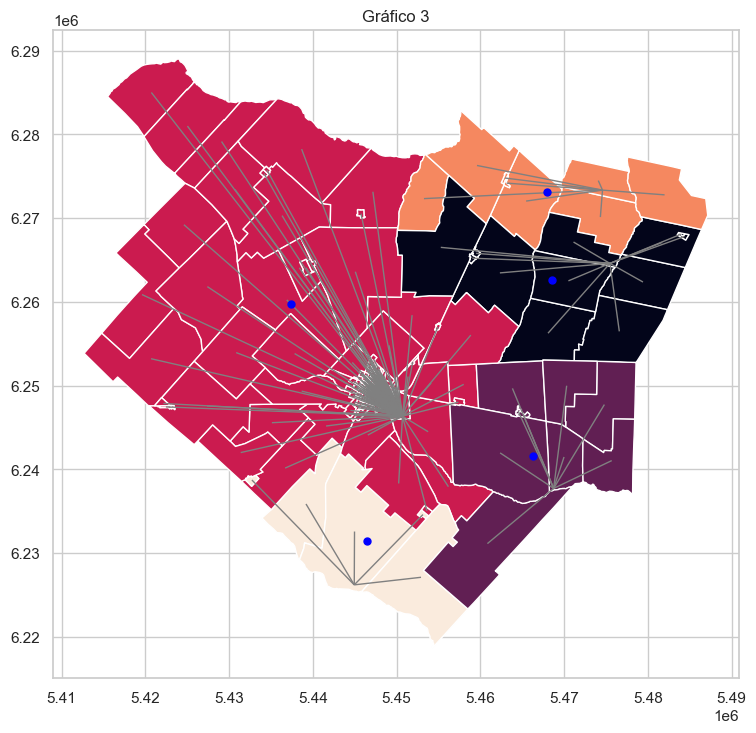

In [105]:
# Asignar las geometrías de los centroides a los puntos
centroides_clusters['geometry'] = centroides_clusters['geometry_y'].fillna(centroides_clusters['geometry_x'])

# Borrar las geometrías antiguas y setear de nuevo la geometry
centroides_clusters = centroides_clusters.drop(columns=['geometry_x','geometry_y'])
centroides_clusters = centroides_clusters.set_geometry('geometry')

# Mostramos ambos conjuntos de datos
ax = radios_censales.plot(edgecolor='white', column='cluster', figsize=(10, 8), zorder=1)
conexiones_gdf.plot(ax=ax, color='gray', linewidth=1, zorder=1)
centroides_clusters.plot(ax=ax, color='blue', markersize=25, zorder=2)
plt.title('Gráfico 3')

Gráfico 3.- En este paso K-means hace la actualización de centroides desplazando el punto desde la unión de todas las líneas hacia el centro de masa de cada polygono.

#### Paso 4 - Reasignación de puntos
Reutilizamos el paso 2

Text(0.5, 1.0, 'Gráfico 4')

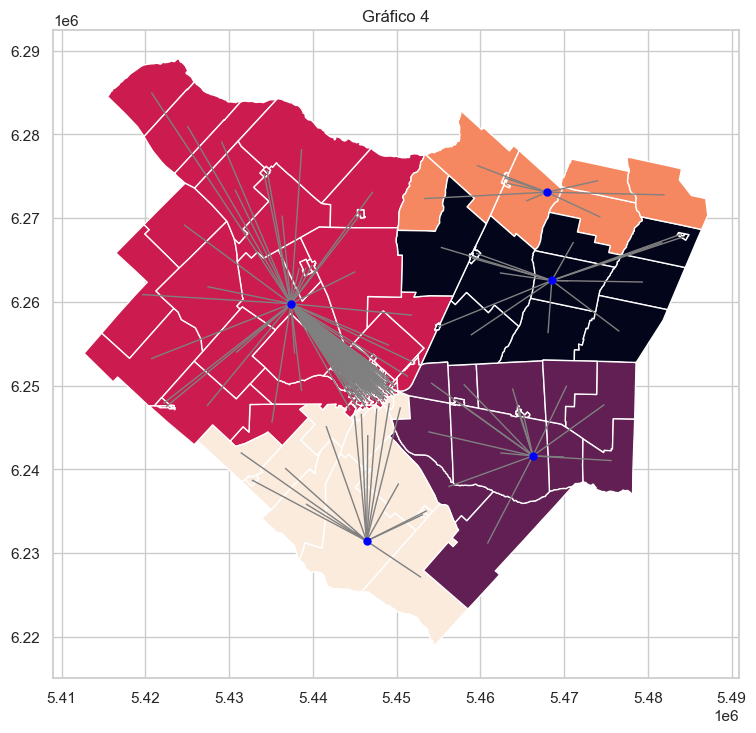

In [106]:
# Crear una lista para almacenar las distancias al clúster más cercano
conexiones = []

# Iterar sobre los radios_censales y calcular la distancia al clúster más cercano
for idx, radio in radios_censales.iterrows():
    radio_geom = radio.geometry.centroid
    centroide_mas_cercana_idx = nearest_points(radio_geom, centroides_clusters.unary_union)[1]
    centroide_mas_cercana = centroides_clusters[centroides_clusters.geometry == centroide_mas_cercana_idx].iloc[0]
    etiqueta_centroide_cercana = centroide_mas_cercana['cluster']
    radios_censales.at[idx, 'cluster'] = etiqueta_centroide_cercana
    linea_entre_puntos = LineString([radio_geom, centroide_mas_cercana_idx])
    conexiones.append(linea_entre_puntos)

# Convierte la lista de conexiones a un GeoDataFrame para visualizarla
conexiones_gdf = gpd.GeoDataFrame(geometry=conexiones, crs=radios_censales.crs)

# Mostramos ambos conjuntos de datos
ax = radios_censales.plot(edgecolor='white', column='cluster', figsize=(10, 8), zorder=1)
conexiones_gdf.plot(ax=ax, color='gray', linewidth=1, zorder=1)
centroides_clusters.plot(ax=ax, color='blue', markersize=25, zorder=2)
plt.title('Gráfico 4')

Gráfico 4.- Vemos otra vez las conexiones al centroide

#### Paso 5 - Iteración
Comienza la iteración hasta que se cumplan los parámetros de convergencia.

### Aplicando K-means con sklearn
Sklearn trae una implementación de K-means para ser utilizada de manera muy práctica, la veremos a continuación:

In [107]:
# Volvemos a tomar la capa de radios censales y nos quedaremos con su geometría
radios_censales = radios_censales[['geometry']]

# Calculamos las coordenadas X e Y de su centroide
radios_censales['X'] = radios_censales.geometry.centroid.x
radios_censales['Y'] = radios_censales.geometry.centroid.y

# Creamos un DataFrame eliminando la columna geometry. Es necesario para aplicar KMeans
radios_censales_df = radios_censales.drop(columns='geometry')

# Mostramos el resultado
radios_censales_df

X             Y
0    5.446139e+06  6.250486e+06
1    5.447266e+06  6.249815e+06
2    5.420722e+06  6.284994e+06
3    5.425030e+06  6.280987e+06
4    5.465461e+06  6.272031e+06
..            ...           ...
173  5.449822e+06  6.249165e+06
174  5.447343e+06  6.252298e+06
175  5.446324e+06  6.249952e+06
176  5.446597e+06  6.250482e+06
177  5.439887e+06  6.264363e+06

[178 rows x 2 columns]

Text(0.5, 1.0, 'Gráfico 5')

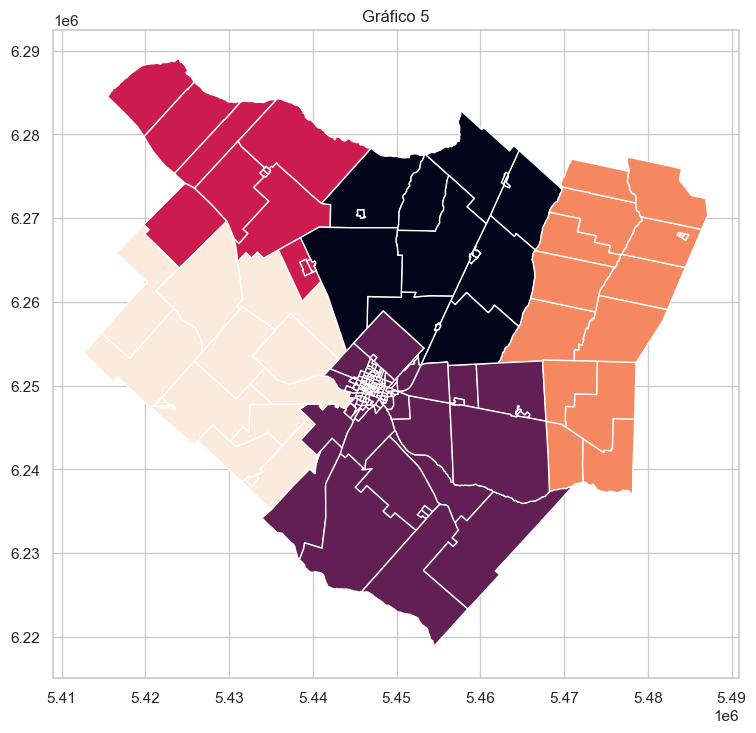

In [108]:
from sklearn.cluster import KMeans

# Cantidad de clúster a formar
num_cluster = 5

# Creamos el objeto KMeans con una configuración inicial
kmeans_radios = KMeans(n_clusters=num_cluster, n_init=1)

# Entrenamos y predecimos. Las clases se guardan en radios censales (GeoDataFrame)
radios_censales['cluster'] = kmeans_radios.fit_predict(radios_censales_df)

# Visualizamos el resultado
ax = radios_censales.plot(edgecolor='white', column='cluster', figsize=(10, 8), zorder=1)
plt.title('Gráfico 5')

Gráfico 5.- Podemos ver nuestra clusterización en 5 categorías

# Conclusión 
En resumen, este trabajo abordó tres temas fundamentales en el análisis de datos: scraping de noticias, predicción de precios y análisis geoespacial. Cada sección se enfocó en técnicas y herramientas específicas para obtener, limpiar, analizar y visualizar datos relevantes en cada área. Estas habilidades son valiosas en el campo de la tecnología y la toma de decisiones basadas en datos, y este trabajo proporciona una visión integral de su aplicación en situaciones del mundo real.